<a href="https://colab.research.google.com/github/nathpignaton/criminalidade_sp/blob/main/2509_MVP_Registros_de_Criminalidade_no_Estado_de_S%C3%A3o_Paulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Análise dos Registros Criminais do Estado de São Paulo
**Autor:** Nathalia Araújo Pignaton  

**Data:** 21/09/2025

**Matrícula:** 4052024001110

**Dataset:** [São Paulo Dados Criminais (SPDC)](https://www.ssp.sp.gov.br/estatistica/consultas)


## 0. Escopo, objetivo e definição do problema

#### Descrição do Problema

Este MVP investiga padrões de associação de registro de criminalidade no estado de São Paulo, a partir dos Boletins de Ocorrência (jan/2022 a jun/2025).
O objetivo inicial era responder o que caracteriza esses contextos, esboçando regras de associação.

**Questão central:** Descrever contextos recorrentes associados a concentração de determinadas naturezas de crime no estado de São Paulo.

**Escopo:** análise descritiva e exploratória, sem modelos preditivos.

**Tipo de tarefa:** clusterização

**Área de aplicação:** dados tabulares

**Valor para o usuário:**
* Explicabilidade dos contextos: regras de associação revelam “em quais condições” os registros ocorrem, apoiando intervenções específicas e comunicáveis a stakeholders.

#### Sobre os dados escolhidos

Neste trabalho vamos processar os dados abertos de crimes do estado de São Paulo, de janeiro de 2022 a junho de 2025, disponibilizados no portal de transparência do estado, complementados pelo dicionário de dados fornecido pela Secretaria de Segurança Pública do estado de São Paulo.

Os dados completos (para todo o estado) podem ser encontrados na aba de [estatísticas](https://www.ssp.sp.gov.br/estatistica) do portal de transparência, mais especificamente na parte de [consultas](https://www.ssp.sp.gov.br/estatistica/consultas).

Quanto ao dicionário de dados, como eu já tinha a intenção de analisar esses dados e por esses dados serem oficiais do estado de São Paulo, solicitei no portal [Fala SP](https://fala.sp.gov.br/) um dicionário de todos os atributos contidos neles.

Além desses dados, vamos utilizar a base do IBGE de dados demográficos do estado de São Paulo, encontrada nas [estatísticas de cidades e estados](https://www.ibge.gov.br/cidades-e-estados/sp/sao-paulo.html) no site do IBGE.

#### Informações importantes sobre dados criminais

Quando vamos utilizar dados criminais, precisamos tomar certo cuidado para realizar as análises e interpretações. Recomendo a leitura do Manual de Interpretação de Dados Criminais, que pode ser baixado na aba de [relatórios e estudos do portal de transparência](https://www.ssp.sp.gov.br/estatistica/relatorios-e-estudos), mas vamos destacar algumas premissas importantes e que se relacionam com o nosso estudo:

##### **"Cifra negra"**
Para que um crime faça parte das estatísticas oficiais são necessárias três etapas sucessivas: **o crime deve ser detectado, notificado às autoridades policiais e por último registrado no boletim de ocorrência**. Pesquisas de vitimização realizadas no Brasil sugerem que, em média, os organismos
policiais **registram apenas um terço dos crimes ocorridos**, percentual que varia de acordo com o delito. *(Os dois terços não registrados são referidos como "cifra negra".)*

Além disso, o aumento das estatísticas oficiais de criminalidade podem estar refletindo flutuações causadas por práticas policiais mais ou menos intensas, ou por modificações de ordem legislativa, ou administrativa.

(Retirado do Manual de Interpretação de Dados Criminais)

#### Descrição do Dataset

**Tabela de Atributos**
|Atributos|Descrição|
|---|---|
|ANO\_BO|Ano do Boletim|
|ANO\_ESTATISTICA|Ano em que a ocorrência foi inserida na estatística oficial |
|BAIRRO|Bairro da Ocorrência|
|CIDADE|Cidade de Registro|
|DATA\_COMUNICACAO|Data da Comunicação|
|DATA\_OCORRENCIA\_BO|Data da Ocorrência|
|DESC\_PERIODO|Período da Ocorrência|
|DESCR\_CONDUTA|Tipo de local ou circunstancia que qualifica a ocorrencia|
|DESCR\_TIPOLOCAL|Descreve grupo de tipos de locais onde se deu o fato|
|HORA\_OCORRENCIA\_BO|Hora da Ocorrência|
|LATITUDE|Latitude da Ocorrência|
|LOGRADOURO|Logradouro dos fatos|
|LONGITUDE|Longitude da Ocorrência|
|MÊS ESTATISTICA|Mês em que a ocorrência foi inserida na estatística oficial |
|NATUREZA\_APURADA|Natureza de Publicação|
|NOME\_DELEGACIA|Delegacia responsável pelo registro|
|NOME\_DELEGACIA\_CIRCUNSCRIÇÃO|Delegacia de Circunscrição|
|NOME\_DEPARTAMENTO|Departamento responsável pelo registro|
|NOME\_DEPARTAMENTO\_CIRCUNSCRIÇÃO|Departamento de Circunscrição|
|NOME\_MUNICIPIO\_CIRCUNSCRIÇÃO|Município da Delegacia de Circunscrição|
|NOME\_SECCIONAL|Delegacia Seccional responsável pelo registro|
|NOME\_SECCIONAL\_CIRCUNSCRIÇÃO|Seccional de Circunscrição|
|NUM\_BO|Número do Boletim|
|NUMERO\_LOGRADOURO|Numero do Logradouro dos fatos|
|RUBRICA|Natureza juridica da ocorrencia|

## 1. Setup Inicial (Necessário rodar essa seção, depois pode pular para a 5)
Antes de iniciar a nossa análise, vamos importar as bibliotecas que vamos utilizar, ajustar algumas configurações do notebook e definir os parâmetros para garantir a reprodutibilidade do estudo.

Importando as bibliotecas

In [1]:
# bibliotecas de análise
import os, random, time, sys, math, re, requests
import pandas as pd
import numpy as np
import unicodedata

# bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

# para baixar os parquets e incluir no github
from google.colab import files

# bibliotecas para pre processamento de dados
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD

# bibliotecas para treinar e avaliar os modelos
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture

# biblioteca auxiliar
from joblib import dump

Definindo parâmetros para facilitar a visualização dos resultados

In [2]:
# configurando a visualização de linhas e colunas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)

pd.options.display.float_format = "{:.2f}".format

# definindo o tema seaborn para o notebook
sns.set_theme(style='darkgrid', palette='colorblind')

Definindo parâmetros para reprodutibilidade

In [3]:
# definindo as configurações para reprodutibilidade
CONFIG = {
    "random_seed": 42,
    "cell_deg": 0.002,          # ~grade espacial (ajustável)
    "pct_limite_area": 0.05,    # top 5% como hotspot (baseline)
    "cap_percentil_dif_registro": 0.99
}

np.random.seed(CONFIG["random_seed"])

## 2. Preparação dos Dados

### 2.1 Coleta e Leitura
Todos os dados estão na mesma pasta do Github, por isso vamos definir essas variáveis abaixo, para utilizar no restante do notebook.

In [7]:
# caminho do GitHub
base_url = "https://raw.githubusercontent.com/nathpignaton/criminalidade_sp/refs/heads/main/bronze"

# anos e meses disponíveis (até o momento)
anos = [2022, 2023, 2024, 2025]
meses_por_ano = {2022: [f"{m:02d}" for m in range(1,13)],
                 2023: [f"{m:02d}" for m in range(1,13)],
                 2024: [f"{m:02d}" for m in range(1,13)],
                 2025: [f"{m:02d}" for m in range(1,7)]}

#### Dados SP Dados Criminais
Para conseguir adicionar e utilizar o arquivo csv no Github, realizei a divisão em subsets, esse separação foi feita através do seguinte código (como o arquivo é muito pesado, não será possível reproduzir essa ação remotamente):


```
# o arquivo xlsx é disponibilizado no site oficial, esse é um exemplo de conversão de um xlsx
crimeSP_1t = pd.read_excel('SPDadosCriminais_2025.xlsx', sheet_name='JAN_A_JUN_2025')
crimeSP_2t = pd.read_excel('SPDadosCriminais_2025.xlsx', sheet_name='JUL_A_DEZ_2025')

dados = pd.concat([crimeSP_1t, crimeSP_2t])

a = str(dados.ANO_ESTATISTICA.unique()[0])[2:4]
m = list(dados.MES_ESTATISTICA.unique())

# separando todos os dados por mês
for i in m:
    df = dados.loc[dados['MES_ESTATISTICA']==i,:]
    if i >= 10:
        df.to_csv(f'{a}{i}SPDC.csv', index=False)
    else:
        df.to_csv(f'{a}0{i}SPDC.csv', index=False)
```

Vamos selecionar as colunas que vamos utilizar, por isso precisamos checar o nome das colunas de todos os bancos ao longo dos anos, é o que faremos abaixo.

In [8]:
# checando o nome das colunas por ano, vamos usar os registros de janeiro
dfs_sample = []
for ano in anos:
    aa = str(ano)[2:]  # '22','23',...
    nome_arquivo = f"{aa}06SPDC.csv"  # mês 6 selecionado como exemplo
    url = f"{base_url}/{ano}/{nome_arquivo}"

    df = pd.read_csv(url)
    dfs_sample.append(df)

len(dfs_sample)

4

Aqui eu selecionei os números, de 0 (2022) a 3 (2025), para o mês 6 (como exemplo), para ver se haviam discrepâncias, como elas existiam, escrevi o código para mapeá-las.

In [9]:
dfs_sample[3].head(3)

,NOME_DEPARTAMENTO,NOME_SECCIONAL,NOME_DELEGACIA,NOME_MUNICIPIO,NUM_BO,ANO_BO,DATA_REGISTRO,DATA_OCORRENCIA_BO,HORA_OCORRENCIA_BO,DESC_PERIODO,DESCR_SUBTIPOLOCAL,BAIRRO,LOGRADOURO,NUMERO_LOGRADOURO,LATITUDE,LONGITUDE,NOME_DELEGACIA_CIRCUNSCRIÇÃO,NOME_DEPARTAMENTO_CIRCUNSCRIÇÃO,NOME_SECCIONAL_CIRCUNSCRIÇÃO,NOME_MUNICIPIO_CIRCUNSCRIÇÃO,RUBRICA,DESCR_CONDUTA,NATUREZA_APURADA,MES_ESTATISTICA,ANO_ESTATISTICA
0,DIPOL - DEPTO DE INTELIGENCIA,DELEGACIA ELETRONICA,DELEGACIA ELETRONICA 1,S.PAULO,HY2402,2025,2025-06-01 00:00:00,2025-05-31 00:00:00,15:00:00,NaN,Metroviário e Ferroviário Metropolitano,SÉ,PRAÇA DA SÉ,0.00,NaN,NaN,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,S.PAULO,Furto (art. 155),Outros,FURTO - OUTROS,6,2025
1,DIPOL - DEPTO DE INTELIGENCIA,DELEGACIA ELETRONICA,DELEGACIA ELETRONICA,S.PAULO,HY2504,2025,2025-06-01 00:00:00,2025-05-31 00:00:00,NaN,De madrugada,Outros,SÉ,RUA HELENA ZERRENER,118.00,-23.55,-46.63,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,S.PAULO,Furto (art. 155),Outros,FURTO - OUTROS,6,2025
2,DIPOL - DEPTO DE INTELIGENCIA,DELEGACIA ELETRONICA,DELEGACIA ELETRONICA 1,S.PAULO,HY2766,2025,2025-06-01 00:00:00,2025-03-01 00:00:00,11:30:00,NaN,Via Pública,CENTRO HISTÓRICO DE SÃO PAULO,AVENIDA PRESTES MAIA,526.00,-23.54,-46.63,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,S.PAULO,Furto (art. 155),Outros,FURTO - OUTROS,6,2025


In [10]:
# calculando a df com o máximo de colunas
mx = max(len(df.columns) for df in dfs_sample)
pd.DataFrame({a: list(df.columns)+[""]*(mx-len(df.columns)) for a,df in zip(anos, dfs_sample)})

# presença de cada coluna por ano
cols = sorted(set().union(*[df.columns for df in dfs_sample]))
presenca = pd.DataFrame({a: [c in df.columns for c in cols] for a, df in zip(anos, dfs_sample)}, index=cols)

# mostrando só as colunas com algum False
presenca_incompletas = presenca[~presenca.all(axis=1)]
presenca_incompletas

,2022,2023,2024,2025
CIDADE,True,True,False,False
DATA_COMUNICACAO,False,True,False,False
DATA_COMUNICACAO_BO,True,False,False,False
DATA_REGISTRO,False,False,True,True
DESCR_PERIODO,True,False,False,False
DESCR_SUBTIPOLOCAL,False,False,True,True
DESCR_TIPOLOCAL,True,True,False,False
DESC_PERIODO,False,True,True,True
NOME_MUNICIPIO,False,False,True,True


Ao observarmos a tabela, podemos inferir a mudança de algumas nomenclaturas:
*   `CIDADE` se tornou `NOME_MUNICIPIO` a partir de 2024
*   `DATA_COMUNICACAO_BO` se tornou `DATA_COMUNICACAO` em 2023 e `DATA_REGISTRO` a partir de 2024
*   `DESCR_PERIODO` se tornou `DESC_PERIODO` de 2023 para frente
*   `DESCR_TIPOLOCAL` se tornou `DESCR_SUBTIPOLOCAL` a partir de 2024

Com isso, vamos realizar essa alteração antes de selecionar as colunas para a leitura dos dados.

In [11]:
# Colunas alvo (inclui variações)
col_alvo = {
    # colunas que não tem diferenças
    "DATA_OCORRENCIA_BO": "DATA_OCORRENCIA_BO",
    "HORA_OCORRENCIA_BO": "HORA_OCORRENCIA_BO",
    "LATITUDE": "LATITUDE",
    "LONGITUDE": "LONGITUDE",
    "BAIRRO": "BAIRRO",
    "NATUREZA_APURADA": "NATUREZA_APURADA",
    "DESCR_CONDUTA": "DESCR_CONDUTA",
    "NUM_BO": "NUM_BO",
    # há apenas um nome para o município_circunscrição - que é o da delegacia responsável, vamos alterar o nome para CIDADE_RESPONSAVEL
    "NOME_MUNICIPIO_CIRCUNSCRIÇÃO": "CIDADE_RESPONSAVEL",
    # alternativa cidade, mantendo novo nome CIDADE_REGISTRO, já que esta é a cidade em que foi aberto o BO
    "CIDADE": "CIDADE_REGISTRO",
    "NOME_MUNICIPIO": "CIDADE_REGISTRO",
    # alternativa descrição do período, mantendo descr_periodo
    "DESCR_PERIODO": "DESCR_PERIODO",
    "DESC_PERIODO": "DESCR_PERIODO",
    # alternativa descrição tipolocal, mantendo descr_tipolocal
    "DESCR_TIPOLOCAL": "DESCR_TIPOLOCAL",
    "DESCR_SUBTIPOLOCAL": "DESCR_TIPOLOCAL",
    # alternativa data de comunicação, mantendo data_comunicacao
    "DATA_COMUNICACAO": "DATA_COMUNICACAO",
    "DATA_COMUNICACAO_BO": "DATA_COMUNICACAO",
    "DATA_REGISTRO": "DATA_COMUNICACAO"}

usecols_whitelist = list(set(col_alvo.keys()))  # aceitar ambas as variações

In [12]:
# definindo a lista para as dfs e o loop para popular a lista
dfs = []
for ano in anos:
    aa = str(ano)[2:]  # '22','23',...
    for mm in meses_por_ano[ano]:
        nome_arquivo = f"{aa}{mm}SPDC.csv"
        url = f"{base_url}/{ano}/{nome_arquivo}"

        df = pd.read_csv(
            url,
            usecols=lambda c: c in usecols_whitelist,
            low_memory=False
        )

        # padronizando nomes
        rename_map = {orig: std for orig, std in col_alvo.items() if orig in df.columns}
        df = df.rename(columns=rename_map)

        # convertento alguns tipos que podem dar erro
        # datas (ISO: YYYY-MM-DD)
        for col in ["DATA_OCORRENCIA_BO", "DATA_COMUNICACAO"]:
          if col in df.columns:
            s = df[col].astype('string').str.strip()
            df[col] = pd.to_datetime(s.str.slice(0,10), errors="coerce", format="%Y-%m-%d")

        # coordenadas numéricas
        for col in ["LATITUDE","LONGITUDE"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")

        final_cols = list(set(col_alvo.values())) # obtendo a lista de nomes padronizados
        for col in final_cols:
            if col not in df.columns:
                df[col] = None # adicionando coluna com nulos se não existir

        dfs.append(df[final_cols]) # selecionar as colunas finais

In [13]:
# concatenando todas as dfs e checando o tamanho
full = pd.concat(dfs, ignore_index=True, sort=False)

full.shape

(4217126, 13)

In [14]:
# checando se as colunas vieram como o esperado
full.head(3)

,DESCR_CONDUTA,DESCR_TIPOLOCAL,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,CIDADE_REGISTRO,DESCR_PERIODO,CIDADE_RESPONSAVEL,LATITUDE,BAIRRO,LONGITUDE,HORA_OCORRENCIA_BO,NATUREZA_APURADA,NUM_BO
0,NaN,Residência,2022-01-13,2021-09-01,S.PAULO,EM HORA INCERTA,S.PAULO,0.00,SE,0.00,NaN,ESTUPRO,AC0851
1,INTERIOR DE VEICULO,Via pública,2022-01-03,2021-12-31,S.PAULO,NaN,S.PAULO,-23.54,Centro Histórico de São Paulo,-46.63,15:20:00,FURTO - OUTROS,4
2,TRANSEUNTE,Terminal/Estação,2022-01-04,2021-12-30,S.PAULO,EM HORA INCERTA,S.PAULO,-23.55,SE,-46.63,NaN,FURTO - OUTROS,7


Como as colunas estão em uma ordem estranha, vou definir uma ordem antes de transformar em parquet.

In [15]:
# definir a ordem desejada das colunas
colunas_ordenadas = [
    'NUM_BO',
    'CIDADE_REGISTRO',
    'CIDADE_RESPONSAVEL',
    'BAIRRO',
    'LATITUDE',
    'LONGITUDE',
    'DATA_COMUNICACAO',
    'DATA_OCORRENCIA_BO',
    'HORA_OCORRENCIA_BO',
    'DESCR_PERIODO',
    'DESCR_TIPOLOCAL',
    'DESCR_CONDUTA',
    'NATUREZA_APURADA'
    ]

# reordenando as colunas
full = full[colunas_ordenadas]

# checando se deu certo
print("Nova ordem das colunas:")
display(full.columns)

Nova ordem das colunas:


Index(['NUM_BO', 'CIDADE_REGISTRO', 'CIDADE_RESPONSAVEL', 'BAIRRO', 'LATITUDE',
       'LONGITUDE', 'DATA_COMUNICACAO', 'DATA_OCORRENCIA_BO',
       'HORA_OCORRENCIA_BO', 'DESCR_PERIODO', 'DESCR_TIPOLOCAL',
       'DESCR_CONDUTA', 'NATUREZA_APURADA'],
      dtype='object')

In [16]:
# salvando parquet bruto
parquet_path = "/content/bo_sp_2022_2025_ate_jun_core.parquet"
full.to_parquet(parquet_path, index=False)

# verificando escrita e tamanho
file_size_mb = os.path.getsize(parquet_path) / (1024 * 1024)
print("Linhas:", len(full))
print("Colunas:", list(full.columns))
print(f"Parquet salvo em: {parquet_path}")
print(f"Tamanho: {file_size_mb:.2f} MB")

Linhas: 4217126
Colunas: ['NUM_BO', 'CIDADE_REGISTRO', 'CIDADE_RESPONSAVEL', 'BAIRRO', 'LATITUDE', 'LONGITUDE', 'DATA_COMUNICACAO', 'DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA_BO', 'DESCR_PERIODO', 'DESCR_TIPOLOCAL', 'DESCR_CONDUTA', 'NATUREZA_APURADA']
Parquet salvo em: /content/bo_sp_2022_2025_ate_jun_core.parquet
Tamanho: 97.30 MB


Com o parquet salvo, os dados estão prontos para serem preparados para o modelo.
Além desses dados, precisamos coletar os dados do IBGE.

#### Dados IBGE
Os dados do IBGE são referentes ao censo de 2022, ele servirá para normalizar o nome das cidades e adicionar informações relativas às características das cidades.

In [17]:
nome_arquivo = 'ibge_sp.csv'
dados_ibge_completos = pd.read_csv(f"{base_url}/IBGE/{nome_arquivo}")

dados_ibge_completos.head(3)

,Município [-],Código [-],Gentílico [-],Prefeito [2025],Área Territorial - km² [2023],População no último censo - pessoas [2022],Densidade demográfica - hab/km² [2022],População estimada - pessoas [2024],Escolarização <span>6 a 14 anos</span> - % [2010],IDHM <span>Índice de desenvolvimento humano municipal</span> [2010],Mortalidade infantil - óbitos por mil nascidos vivos [2022],Total de receitas brutas realizadas - R$ [2023],Total de despesas brutas empenhadas - R$ [2023],PIB per capita - R$ [2021]
0,Adamantina,3500105.00,adamantinense,JOSÉ CARLOS MARTINS TIVERON,411.99,34687.00,84.19,35642.00,97.60,0.79,10.5,286080113.60,274074871.20,38997.12
1,Adolfo,3500204.00,adolfino,RICARDO DI GIORGIO ROBLES,211.06,4351.00,20.62,4478.00,98.60,0.73,-,46693392.52,41404998.46,32578.28
2,Aguaí,3500303.00,aguaiano,GILBERTO LUIZ MORAES SELBER,474.55,32072.00,67.58,32888.00,95.80,0.71,8.11,171102182.70,161253061.80,35551.70


Vamos mudar o nome das colunas para que elas fiquem padronizadas.

In [18]:
# alterando o nome das colunas
dados_ibge_completos.columns = ['MUNICIPIO_IBGE', 'CODIGO_IBGE', 'GENTILICO', 'PREFEITO', 'AREA_TERRITORIAL', 'POPULACAO_CENSO', 'DENSIDADE_DEMOGRAFICA', 'POPULACAO_ESTIMADA[24]',
                                'ESCOLARIZACAO', 'IDHM', 'MORTALIDADE_INFANTIL', 'RECEITAS_BRUTAS_REALIZADAS', 'RECEITAS_BRUTAS_EMPENHADAS', 'PIB_PER_CAPITA']

dados_ibge_completos.columns

Index(['MUNICIPIO_IBGE', 'CODIGO_IBGE', 'GENTILICO', 'PREFEITO',
       'AREA_TERRITORIAL', 'POPULACAO_CENSO', 'DENSIDADE_DEMOGRAFICA',
       'POPULACAO_ESTIMADA[24]', 'ESCOLARIZACAO', 'IDHM',
       'MORTALIDADE_INFANTIL', 'RECEITAS_BRUTAS_REALIZADAS',
       'RECEITAS_BRUTAS_EMPENHADAS', 'PIB_PER_CAPITA'],
      dtype='object')

Vamos manter alguns atributos específicos para as nossas análises:
*  Município e Código
*  Área Territorial [2023]
*  População do último censo [2022] e População estimada - pessoas [2024]
*  Densidade demográfica [2022]
*  PIB per capita [2021]

Não vamos utilizar indicadores de antes de 2010 (Escolaridade e IDH), por serem antigos, também não vamos utilizar informações administrativas nem os dados de Mortalidade Infantil.


In [19]:
# selecionando os atributos que serão úteis
ibge = dados_ibge_completos[['MUNICIPIO_IBGE', 'CODIGO_IBGE', 'AREA_TERRITORIAL', 'POPULACAO_CENSO', 'DENSIDADE_DEMOGRAFICA', 'POPULACAO_ESTIMADA[24]', 'PIB_PER_CAPITA']].copy()

ibge.head(3)

,MUNICIPIO_IBGE,CODIGO_IBGE,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,POPULACAO_ESTIMADA[24],PIB_PER_CAPITA
0,Adamantina,3500105.00,411.99,34687.00,84.19,35642.00,38997.12
1,Adolfo,3500204.00,211.06,4351.00,20.62,4478.00,32578.28
2,Aguaí,3500303.00,474.55,32072.00,67.58,32888.00,35551.70


Em seguida vamos avaliar a integridade de todas as colunas, para isso precisamos realizar ajustes de tipo e normalização dos textos antes de checar se conseguimos realizar as análises que estamos imaginando com esses dados.

### 2.2 Limpeza Inicial
Antes de qualquer análise exploratória, vamos ajustar os tipos de todos os dados e, em seguida, normalizar os textos das colunas de texto.

**Essa limpeza não afeta a divisão de treino e teste para o modelo de machine learning, ela precisa ser feita inicialmente para permanência apenas das colunas que poderemos utilizar e para realizarmos uma análise exploratória que seja consistente.**

#### a) Ajustes de tipos
Vamos começar pela base SPDC (São Paulo Dados Criminais) definida como a df principal, vamos ler o parquet e, em seguida, checar os tipos.negrito

In [20]:
# definindo as informações do parquet
parquet_path = "/content/bo_sp_2022_2025_ate_jun_core.parquet"

# lendo o parquet
spdc_bruto = pd.read_parquet(parquet_path)
spdc_bruto.head(3)

,NUM_BO,CIDADE_REGISTRO,CIDADE_RESPONSAVEL,BAIRRO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,HORA_OCORRENCIA_BO,DESCR_PERIODO,DESCR_TIPOLOCAL,DESCR_CONDUTA,NATUREZA_APURADA
0,AC0851,S.PAULO,S.PAULO,SE,0.00,0.00,2022-01-13,2021-09-01,None,EM HORA INCERTA,Residência,None,ESTUPRO
1,4,S.PAULO,S.PAULO,Centro Histórico de São Paulo,-23.54,-46.63,2022-01-03,2021-12-31,15:20:00,None,Via pública,INTERIOR DE VEICULO,FURTO - OUTROS
2,7,S.PAULO,S.PAULO,SE,-23.55,-46.63,2022-01-04,2021-12-30,None,EM HORA INCERTA,Terminal/Estação,TRANSEUNTE,FURTO - OUTROS


In [21]:
# checando os tipos
spdc_bruto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217126 entries, 0 to 4217125
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   NUM_BO              object        
 1   CIDADE_REGISTRO     object        
 2   CIDADE_RESPONSAVEL  object        
 3   BAIRRO              object        
 4   LATITUDE            float64       
 5   LONGITUDE           float64       
 6   DATA_COMUNICACAO    datetime64[ns]
 7   DATA_OCORRENCIA_BO  datetime64[ns]
 8   HORA_OCORRENCIA_BO  object        
 9   DESCR_PERIODO       object        
 10  DESCR_TIPOLOCAL     object        
 11  DESCR_CONDUTA       object        
 12  NATUREZA_APURADA    object        
dtypes: datetime64[ns](2), float64(2), object(9)
memory usage: 418.3+ MB


Podemos observar que as colunas de texto se mantiveram como `object`, vamos usar o `convert_dtypes` global e ver se ajustamos todas ou, se não funcionar, se precisaremos alterar uma a uma.

In [22]:
spdc_bruto = spdc_bruto.convert_dtypes()
spdc_bruto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217126 entries, 0 to 4217125
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   NUM_BO              string        
 1   CIDADE_REGISTRO     string        
 2   CIDADE_RESPONSAVEL  string        
 3   BAIRRO              string        
 4   LATITUDE            Float64       
 5   LONGITUDE           Float64       
 6   DATA_COMUNICACAO    datetime64[ns]
 7   DATA_OCORRENCIA_BO  datetime64[ns]
 8   HORA_OCORRENCIA_BO  string        
 9   DESCR_PERIODO       string        
 10  DESCR_TIPOLOCAL     string        
 11  DESCR_CONDUTA       string        
 12  NATUREZA_APURADA    string        
dtypes: Float64(2), datetime64[ns](2), string(9)
memory usage: 426.3 MB


Como pudemos observar, quase todos os tipos foram convertidos corretamente, aparentemente faltou apenas `HORA_OCORRENCIA_BO`, que está como `string` ao invés de `datetime64[ns]`, mas para o que vamos utilizar (calcular faixas de tempo para preencher `DESCR_PERIODO`) `string` é o formato correto.
Agora podemos transformar `spdc_bruto` em `spdc_v1` e seguir para a base do IBGE.

In [23]:
# criando a primeira versão limpa
spdc_v1 = spdc_bruto.copy()

Checando a base do IBGE

In [24]:
# checando tipos da base IBGE
ibge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MUNICIPIO_IBGE          658 non-null    object 
 1   CODIGO_IBGE             645 non-null    float64
 2   AREA_TERRITORIAL        645 non-null    float64
 3   POPULACAO_CENSO         645 non-null    float64
 4   DENSIDADE_DEMOGRAFICA   645 non-null    float64
 5   POPULACAO_ESTIMADA[24]  645 non-null    float64
 6   PIB_PER_CAPITA          645 non-null    float64
dtypes: float64(6), object(1)
memory usage: 36.2+ KB


Aqui podemos observar que a coluna de texto está armazenada como `object` e que todas as colunas de número estão como `float`, mesmo as que possuem números inteiros como `CODIGO_IBGE` e `POPULACAO_CENSO`, também vamos aplicar a `convert_dtypes` e conferir o resultado.

In [25]:
# usando convert_dtypes
ibge = ibge.convert_dtypes()
ibge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MUNICIPIO_IBGE          658 non-null    string 
 1   CODIGO_IBGE             645 non-null    Int64  
 2   AREA_TERRITORIAL        645 non-null    Float64
 3   POPULACAO_CENSO         645 non-null    Int64  
 4   DENSIDADE_DEMOGRAFICA   645 non-null    Float64
 5   POPULACAO_ESTIMADA[24]  645 non-null    Int64  
 6   PIB_PER_CAPITA          645 non-null    Float64
dtypes: Float64(3), Int64(3), string(1)
memory usage: 40.1 KB


Podemos observar que todos as colunas foram convertidas para o tipo correto, agora vamos seguir para a normalização das colunas de texto.

#### b) Normalizando os textos & removendo nulos
A nossa base principal possui diversos nomes que precisam ser padronizados antes de realizar nossas análises de exploração. O mesmo serve para a base do IBGE, as colunas que necessitam de normalização são:

**Base SPDC**
*   CIDADE_REGISTRO
*   CIDADE_RESPONSAVEL
*   BAIRRO
*   DESCR_PERIODO
*   DESCR_TIPOLOCAL
*   DESCR_CONDUTA
*   NATUREZA_APURADA

**Base IBGE**
*   MUNICIPIO_IBGE

Primeiro, vamos definir algumas funções para normalização de textos.

In [26]:
# definir função de normalização de textos
def normalizar_texto(text):
    if pd.isna(text):
        return text
    # convertendo para string e minúsculas
    text = str(text).lower()
    # normalizando Unicode (NFD) para separar base character e acentos
    text = unicodedata.normalize('NFD', text)
    # removendo caracteres combinantes (acentos) e manter apenas letras (a-z), números e espaços
    text = text.encode('ascii', 'ignore').decode('utf-8')
    # substituindo hifens por espaços
    text = text.replace('-', ' ')
    # retirando os pontos do meio do texto
    text = text.replace('.', '')
    # retirando os apóstrofos
    text = text.replace("'", ' ')
    # substituindo múltiplos espaços por um único espaço
    text = re.sub(r' +', ' ', text)
    # removendo espaços extras no início e fim
    text = text.strip()
    return text

In [27]:
# função para normalizar uma coluna em um DataFrame
def normalizar_coluna(df, coluna):
    df[f"{coluna}_clean"] = df[coluna].apply(normalizar_texto)

Como a base do IBGE é mais simples, vamos normalizá-la primeiro.

In [28]:
# normalizando a coluna string da df IBGE
normalizar_coluna(ibge, 'MUNICIPIO_IBGE')

Os municípios foram normalizados, porém, podemos observar uma série de linhas ao final do dataframe que contém informações que não são dos municípios, vamos removê-las.
Para isso vamos remover todas as entradas que não possuem `CODIGO_IBGE`.

Além disso, vamos manter apenas a coluna com os nomes dos municípios ajustados.

In [29]:
# Remover linhas onde CODIGO_IBGE é nulo
ibge = ibge.dropna(subset=['CODIGO_IBGE'])

# Checar o resultado
ibge.tail()

,MUNICIPIO_IBGE,CODIGO_IBGE,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,POPULACAO_ESTIMADA[24],PIB_PER_CAPITA,MUNICIPIO_IBGE_clean
640,Votorantim,3557006,184.19,127923,694.53,132849,31487.90,votorantim
641,Votuporanga,3557105,420.70,96634,229.70,100159,40190.41,votuporanga
642,Zacarias,3557154,319.06,2692,8.44,2761,46763.19,zacarias
643,Chavantes,3557204,188.73,12211,64.70,12411,21448.28,chavantes
644,Estiva Gerbi,3557303,74.14,11295,152.34,11566,33843.06,estiva gerbi


In [30]:
ibge_clean = ibge.copy()
ibge_clean['MUNICIPIO_IBGE'] = ibge_clean['MUNICIPIO_IBGE_clean']
ibge_clean.drop(['MUNICIPIO_IBGE_clean'], inplace=True, axis=1)
ibge_clean.head()

,MUNICIPIO_IBGE,CODIGO_IBGE,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,POPULACAO_ESTIMADA[24],PIB_PER_CAPITA
0,adamantina,3500105,411.99,34687,84.19,35642,38997.12
1,adolfo,3500204,211.06,4351,20.62,4478,32578.28
2,aguai,3500303,474.55,32072,67.58,32888,35551.70
3,aguas da prata,3500402,142.67,7369,51.65,7470,25297.02
4,aguas de lindoia,3500501,60.13,17930,298.21,18245,30971.23


Agora vamos criar uma lista com as colunas de texto para normalizar na base SPDC e normalizá-las uma a uma.

Alterar textos demora bastante e, para otimizar essa etapa do trabalho, vamos checar os nulos antes de realizar cada alteração.

Vamos checar a quantidade de valores únicos por coluna de texto.

In [31]:
# lista para normalização do SPDC
spdc_normalizar = ['CIDADE_REGISTRO', 'CIDADE_RESPONSAVEL', 'BAIRRO', 'DESCR_PERIODO', 'DESCR_TIPOLOCAL', 'DESCR_CONDUTA', 'NATUREZA_APURADA']

for c in spdc_normalizar:
    print(f"Coluna: {c} --|-- Valores únicos: {spdc_v1[c].nunique()}")

Coluna: CIDADE_REGISTRO --|-- Valores únicos: 1347
Coluna: CIDADE_RESPONSAVEL --|-- Valores únicos: 646
Coluna: BAIRRO --|-- Valores únicos: 82221
Coluna: DESCR_PERIODO --|-- Valores únicos: 15
Coluna: DESCR_TIPOLOCAL --|-- Valores únicos: 446
Coluna: DESCR_CONDUTA --|-- Valores únicos: 172
Coluna: NATUREZA_APURADA --|-- Valores únicos: 38


Podemos observar um volume grande de informações para tratar. Antes de seguir, vamos checar a distribuição de nulos e tomar algumas decisões sobre os dados.

In [32]:
# total de registros
total = spdc_v1.shape[0]

# contagem de nulos por coluna
null_abs = spdc_v1.isna().sum()

# Percentual de nulos por coluna em relação ao total de registros
null_pct = (null_abs / total) * 100

resumo_nulos = pd.DataFrame({
    'nulos_absoluto': null_abs,
    'nulos_percentual': null_pct
}).sort_values('nulos_absoluto', ascending=False)

resumo_nulos['nulos_percentual'] = resumo_nulos['nulos_percentual'].round(2)

resumo_nulos

,nulos_absoluto,nulos_percentual
DESCR_PERIODO,3056824,72.49
HORA_OCORRENCIA_BO,1284350,30.46
DESCR_CONDUTA,1089712,25.84
LATITUDE,434732,10.31
LONGITUDE,434731,10.31
BAIRRO,65775,1.56
DATA_OCORRENCIA_BO,27799,0.66
DESCR_TIPOLOCAL,21407,0.51
DATA_COMUNICACAO,3444,0.08
CIDADE_REGISTRO,2,0.00


Observando acima, vemos que o maior volume de dados faltantes vem de `DESCR_PERIODO`, seguido de `HORA_OCORRENCIA_BO`. Esses dois atributos são complementares, porque a Descrição do Período são as faixas de horário, que podem ser calculadas com o `HORA_OCORRENCIA_BO`.
Antes de retirar os nulos, vamos popular a coluna de `DESCR_PERIODO` com base na coluna `HORA_OCORRENCIA_BO`, para isso precisamos analisar os dois atributos.

Os atributos com menos de 1% de nulos também terão esses registros removidos.

In [33]:
# removendo os nulos das colunas com menos de 1% de nulos
spdc_v1 = spdc_v1.dropna(subset=['CIDADE_REGISTRO', 'DATA_COMUNICACAO', 'DESCR_TIPOLOCAL', 'DATA_OCORRENCIA_BO'])

##### `DESCR_PERIODO` e `HORA_OCORRENCIA_BO`
Primeiro vamos checar os valores únicos de `DESCR_PERIODO`.

In [34]:
spdc_v1['DESCR_PERIODO'].value_counts()

,count
DESCR_PERIODO,
A tarde,212923
A noite,202761
Pela manhã,192026
De madrugada,166957
Em hora incerta,98679
DE MADRUGADA,52613
A NOITE,52134
A TARDE,51766
PELA MANHÃ,48705


Vamos aplicar a fórmula de normalização dos textos e avaliar novamente.

In [35]:
normalizar_coluna(spdc_v1, 'DESCR_PERIODO')
spdc_v1['DESCR_PERIODO_clean'].value_counts()

,count
DESCR_PERIODO_clean,
a tarde,265913
a noite,256387
pela manha,242180
de madrugada,222347
em hora incerta,151651


Como vimos anteriormente, essa coluna é complementar ao `HORA_OCORRENCIA_BO`. Agora vamos definir as faixas de tempo para preencher os dados faltantes com as classes com base em `HORA_OCORRENCIA_BO`:
*   De madrugada: 00:00–05:59 - Período de baixa atividade, anterior ao início típico da jornada.
*   Pela manhã: 06:00–11:59 - Início do dia útil, luz matinal.
*   À tarde: 12:00–17:59 - Período pós-almoço até o fim da tarde.
*   À noite: 18:00–23:59 - Início da noite até o fim do dia.

Mas antes de aplicar essas faixas horárias, precisamos converter a coluna `HORA_OCORRENCIA_BO` em datetime.

In [36]:
# convertendo a coluna de string para datetime
spdc_v1['HORA_OCORRENCIA_BO'] = pd.to_datetime(spdc_v1['HORA_OCORRENCIA_BO'].str.strip(), errors='coerce')
spdc_v1['HORA_OCORRENCIA_BO'].info()

/tmp/ipython-input-4273267264.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  spdc_v1['HORA_OCORRENCIA_BO'] = pd.to_datetime(spdc_v1['HORA_OCORRENCIA_BO'].str.strip(), errors='coerce')


<class 'pandas.core.series.Series'>
Index: 4164484 entries, 0 to 4217125
Series name: HORA_OCORRENCIA_BO
Non-Null Count    Dtype         
--------------    -----         
2925531 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 63.5 MB


Agora vamos criar a função de faixas de horário e aplicar à `HORA_OCORRENCIA_BO`, criando a coluna temporária `FAIXA_HORARIA`.

In [37]:
# criando função
def faixa_horaria(dt):
    if pd.isna(dt):
        return np.nan
    h = dt.hour
    # limites: [00:00, 06:00), [06:00, 12:00), [12:00, 18:00), [18:00, 24:00)
    if 0 <= h < 6:
        return 'de madrugada'
    elif 6 <= h < 12:
        return 'pela manha'
    elif 12 <= h < 18:
        return 'a tarde'
    else:
        return 'a noite'

spdc_v1['FAIXA_HORARIA'] = spdc_v1['HORA_OCORRENCIA_BO'].apply(faixa_horaria)

In [38]:
# checando a coluna temporária
spdc_v1['FAIXA_HORARIA'].value_counts()

,count
FAIXA_HORARIA,
a noite,940593
a tarde,804308
pela manha,689774
de madrugada,490856


Com a criação da coluna temporária, vamos checar os nulos da coluna `DESCR_PERIODO`, substituir os valores faltantes pelos valor em `FAIXA_HORARIA` e comparar os resultados.

In [39]:
# checando os nulos & value counts antes do preenchimento dos nulos
print(f"Total de nulos: {spdc_v1['DESCR_PERIODO_clean'].isna().sum()}")
print(f"Percentual de nulos: {(spdc_v1['DESCR_PERIODO_clean'].isna().sum()/spdc_v1.shape[0])*100:.2f}")
s = spdc_v1['DESCR_PERIODO_clean']
vc = s.value_counts(dropna=False)
vp = s.value_counts(dropna=False, normalize=True)

out = pd.concat(
    [vc.rename('contagem'),
     (vp.mul(100)).round(1).rename('proporcao_%')],
    axis=1
).sort_values('contagem', ascending=False)

out

Total de nulos: 3026006
Percentual de nulos: 72.66


,contagem,proporcao_%
DESCR_PERIODO_clean,,
<NA>,3026006,72.70
a tarde,265913,6.40
a noite,256387,6.20
pela manha,242180,5.80
de madrugada,222347,5.30
em hora incerta,151651,3.60


In [40]:
# substituindo os valores nulos de DESCR_PERIODO pelos valores criados em FAIXA_HORARIA
spdc_v1['DESCR_PERIODO'] = spdc_v1['DESCR_PERIODO_clean'].fillna(spdc_v1['FAIXA_HORARIA'])

# removendo a coluna antiga DESCR_PERIODO
spdc_v1 = spdc_v1.drop(columns=['DESCR_PERIODO_clean'])

# checando o resultado
spdc_v1['DESCR_PERIODO'].value_counts()

,count
DESCR_PERIODO,
a noite,1196969
a tarde,1070199
pela manha,931936
de madrugada,713188
em hora incerta,151651


In [41]:
# checando os nulos de DESCR_PERIODO agora
print(f"Total de nulos: {spdc_v1['DESCR_PERIODO'].isna().sum()}")
print(f"Percentual de nulos: {(spdc_v1['DESCR_PERIODO'].isna().sum()/spdc_v1.shape[0])*100:.2f}")
s = spdc_v1['DESCR_PERIODO']
vc = s.value_counts(dropna=False)
vp = s.value_counts(dropna=False, normalize=True)

out = pd.concat(
    [vc.rename('contagem'),
     (vp.mul(100)).round(1).rename('proporcao_%')],
    axis=1
).sort_values('contagem', ascending=False)

out

Total de nulos: 100541
Percentual de nulos: 2.41


,contagem,proporcao_%
DESCR_PERIODO,,
a noite,1196969,28.70
a tarde,1070199,25.70
pela manha,931936,22.40
de madrugada,713188,17.10
em hora incerta,151651,3.60
NaN,100541,2.40


Aqui podemos ver que o total de nulos desceu de 72,49% para 2,94%. Provavelmente o padrão de preenchimento era inicialmente a hora da ocorrência, mas agora temos as informações mais normalizadas. Vamos remover esses 2,9% de registros sem `DESCR_PERIODO`.

Por fim, não precisamos mais da coluna `HORA_OCORRENCIA_BO` nem `FAIXA_HORARIA`, elas serão removidas.

In [42]:
# removendo os 2,9% de dados sem DESCR_PERIODO
spdc_v1 = spdc_v1.dropna(subset=['DESCR_PERIODO'])

spdc_v1.isna().sum()

,0
NUM_BO,0
CIDADE_REGISTRO,0
CIDADE_RESPONSAVEL,0
BAIRRO,61045
LATITUDE,405973
LONGITUDE,405972
DATA_COMUNICACAO,0
DATA_OCORRENCIA_BO,0
HORA_OCORRENCIA_BO,1138412
DESCR_PERIODO,0


In [43]:
# removendo hora_ocorrencia_bo e faixa_horaria
spdc_v1 = spdc_v1.drop(columns=['HORA_OCORRENCIA_BO', 'FAIXA_HORARIA'])
spdc_v1.head(3)

,NUM_BO,CIDADE_REGISTRO,CIDADE_RESPONSAVEL,BAIRRO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,DESCR_TIPOLOCAL,DESCR_CONDUTA,NATUREZA_APURADA
0,AC0851,S.PAULO,S.PAULO,SE,0.00,0.00,2022-01-13,2021-09-01,em hora incerta,Residência,<NA>,ESTUPRO
1,4,S.PAULO,S.PAULO,Centro Histórico de São Paulo,-23.54,-46.63,2022-01-03,2021-12-31,a tarde,Via pública,INTERIOR DE VEICULO,FURTO - OUTROS
2,7,S.PAULO,S.PAULO,SE,-23.55,-46.63,2022-01-04,2021-12-30,em hora incerta,Terminal/Estação,TRANSEUNTE,FURTO - OUTROS


##### `DESCR_CONDUTA`
Essa coluna possui 25% dos valores nulos, um percentual muito alto. Vamos investigar um pouco mais essas informações.

In [44]:
# dando uma olhada nos valores
spdc_v1['DESCR_CONDUTA'].value_counts().head(3)

,count
DESCR_CONDUTA,
Outros,1315562
OUTROS,335509
Veículo,308767


Percebemos uma falta de padroninzação nos textos, então vamos realizar essa padronização com a função.

In [45]:
normalizar_coluna(spdc_v1, 'DESCR_CONDUTA')

In [46]:
print(f"Total de Nulos: {(spdc_v1['DESCR_CONDUTA_clean'].isna().sum()/spdc_v1.shape[0])*100:.2f}%")
print(f"Total de 'Outros': {(spdc_v1['DESCR_CONDUTA_clean'].value_counts()['outros']/spdc_v1.shape[0])*100:.2f}%")

Total de Nulos: 26.08%
Total de 'Outros': 41.26%


Esse campo possui um volume muito grande de nulos e 'outros', o que prejudica profundamente a análise. Por isso vamos remover essa coluna.

In [47]:
# removendo as colunas
spdc_v1.drop(columns=['DESCR_CONDUTA_clean', 'DESCR_CONDUTA'], inplace=True)

# checando os resultados
spdc_v1.head(3)

,NUM_BO,CIDADE_REGISTRO,CIDADE_RESPONSAVEL,BAIRRO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,DESCR_TIPOLOCAL,NATUREZA_APURADA
0,AC0851,S.PAULO,S.PAULO,SE,0.00,0.00,2022-01-13,2021-09-01,em hora incerta,Residência,ESTUPRO
1,4,S.PAULO,S.PAULO,Centro Histórico de São Paulo,-23.54,-46.63,2022-01-03,2021-12-31,a tarde,Via pública,FURTO - OUTROS
2,7,S.PAULO,S.PAULO,SE,-23.55,-46.63,2022-01-04,2021-12-30,em hora incerta,Terminal/Estação,FURTO - OUTROS


Agora vamos seguir para os dados de `LATITUDE` E `LONGITUDE`

##### `LATITUDE` e `LONGITUDE` + `NATUREZA_APURADA`

Para definir se vamos ou não excluir os nulos, precisamos observar aspectos específicos deste atributo.

In [48]:
# checando os nulos para latitude e longitude
print(f"Total de nulos em LATITUDE: {spdc_v1['LATITUDE'].isna().sum()} ({(spdc_v1['LATITUDE'].isna().sum()/spdc_v1.shape[0])*100:.2f}%)")
print(f"Total de nulos em LONGITUDE: {spdc_v1['LONGITUDE'].isna().sum()} ({(spdc_v1['LONGITUDE'].isna().sum()/spdc_v1.shape[0])*100:.2f}%)")

Total de nulos em LATITUDE: 405973 (9.99%)
Total de nulos em LONGITUDE: 405972 (9.99%)


Além disso, precisamos checar quantos registros de `LATITUDE` e `LONGITUDE` estão registrados como 0 ou 0.0

In [49]:
# Contando registros com Latitude ou Longitude igual a 0/0.0
lat_zero_count = (spdc_v1['LATITUDE'] == 0).sum()
lon_zero_count = (spdc_v1['LONGITUDE'] == 0).sum()

# Calculando o total de registros em spdc_v3 para o percentual
total_v3 = spdc_v1.shape[0]

print(f"Número de registros com LATITUDE igual a 0 ou 0.0: {lat_zero_count} ({(lat_zero_count/total_v3)*100:.2f}%)")
print(f"Número de registros com LONGITUDE igual a 0 ou 0.0: {lon_zero_count} ({(lon_zero_count/total_v3)*100:.2f}%)")

Número de registros com LATITUDE igual a 0 ou 0.0: 690273 (16.99%)
Número de registros com LONGITUDE igual a 0 ou 0.0: 690273 (16.99%)


Vamos transformar esses registros inválidos (0 e 0.0) em NA, para consolidar a análise.

In [50]:
# substituindo 0.0 por NaN nas colunas LATITUDE e LONGITUDE
spdc_v1['LATITUDE'] = spdc_v1['LATITUDE'].replace(0, np.nan)
spdc_v1['LONGITUDE'] = spdc_v1['LONGITUDE'].replace(0, np.nan)

# checar se a substituição funcionou
print(f"Total de nulos em LATITUDE: {spdc_v1['LATITUDE'].isna().sum()} ({(spdc_v1['LATITUDE'].isna().sum()/spdc_v1.shape[0])*100:.2f}%)")
print(f"Total de nulos em LONGITUDE: {spdc_v1['LONGITUDE'].isna().sum()} ({(spdc_v1['LONGITUDE'].isna().sum()/spdc_v1.shape[0])*100:.2f}%)")

Total de nulos em LATITUDE: 1096246 (26.97%)
Total de nulos em LONGITUDE: 1096245 (26.97%)


26,88% é um valor relativamente alto para a nossa análise, além disso precisamos avaliar se remover esses registros afeta a representatividade dos dados (se faltam latitude e longitude em cidades, naturezas apuradas ou em momentos de tempo específicos - meses e anos).
Para isso, precisamos observar os nulos nas colunas `CIDADE_RESPONSAVEL` e `NATUREZA_APURADA` e nas variáveis de tempo.

Primeiro vamos normalizar as duas colunas de acordo com a função de normalizar textos.

In [51]:
# normalizando cidade_responsavel
normalizar_coluna(spdc_v1, 'CIDADE_RESPONSAVEL')

# normalizando natureza_apurada
normalizar_coluna(spdc_v1, 'NATUREZA_APURADA')

In [52]:
spdc_v1['CIDADE_RESPONSAVEL_clean'].nunique()

646

In [53]:
print(f"Total de valores únicos: {spdc_v1['NATUREZA_APURADA_clean'].nunique()}")
spdc_v1['NATUREZA_APURADA_clean'].value_counts().head(4)

Total de valores únicos: 24


,count
NATUREZA_APURADA_clean,
furto outros,1851226
roubo outros,727989
lesao corporal dolosa,512935
furto de veiculo,328233


In [54]:
# filtrando df_total
df_total = spdc_v1[(spdc_v1["NATUREZA_APURADA_clean"].notna()) & (spdc_v1["CIDADE_RESPONSAVEL_clean"].notna())].copy()

# filtrando df_geo a partir de df_total
df_geo = df_total[(df_total["LATITUDE"].notna()) & (df_total["LONGITUDE"].notna())].copy()

# filtrando df_nogeo a partir de df_total
df_nogeo = df_total[(df_total["LATITUDE"].isna()) | (df_total["LONGITUDE"].isna())].copy()

# totais
total_total = len(df_total)
total_geo = len(df_geo)
total_nogeo = len(df_nogeo)

# distribuicao por cidade
dist_total_cidade = df_total.groupby("CIDADE_RESPONSAVEL_clean").size().reset_index(name="qtd_total")
dist_total_cidade["perc_total"] = round(dist_total_cidade["qtd_total"] / total_total * 100, 2)

dist_geo_cidade = df_geo.groupby("CIDADE_RESPONSAVEL_clean").size().reset_index(name="qtd_geo")
dist_geo_cidade["perc_geo"] = round(dist_geo_cidade["qtd_geo"] / total_geo * 100, 2)

dist_nogeo_cidade = df_nogeo.groupby("CIDADE_RESPONSAVEL_clean").size().reset_index(name="qtd_nogeo")
dist_nogeo_cidade["perc_nogeo"] = round(dist_nogeo_cidade["qtd_nogeo"] / total_nogeo * 100, 2)

# juntar comparativos
comparativo_cidades = dist_total_cidade \
    .merge(dist_geo_cidade, on="CIDADE_RESPONSAVEL_clean", how="left") \
    .merge(dist_nogeo_cidade, on="CIDADE_RESPONSAVEL_clean", how="left") \
    .fillna(0)

# Calcular o percentual sem geolocalização em relação ao total de registros da cidade
comparativo_cidades['perc_nogeo_na_cidade'] = round(comparativo_cidades['qtd_nogeo'] / comparativo_cidades['qtd_total'] * 100, 2)


print("Comparativo de CIDADES - Total vs Com Geo vs Sem Geo")
comparativo_cidades.sort_values(by="perc_nogeo_na_cidade", ascending=False).head(8)

Comparativo de CIDADES - Total vs Com Geo vs Sem Geo


,CIDADE_RESPONSAVEL_clean,qtd_total,perc_total,qtd_geo,perc_geo,qtd_nogeo,perc_nogeo,perc_nogeo_na_cidade
519,santo antonio da alegria,1,0.00,0.00,0.00,1,0.00,100.00
372,nova castilho,35,0.00,9.00,0.00,26,0.00,74.29
576,srita d oeste,65,0.00,17.00,0.00,48,0.00,73.85
181,fernao,111,0.00,34.00,0.00,77,0.01,69.37
629,uru,80,0.00,25.00,0.00,55,0.01,68.75
487,ribeirao indios,52,0.00,17.00,0.00,35,0.00,67.31
361,murutinga do sul,181,0.00,60.00,0.00,121,0.01,66.85
312,lucianopolis,93,0.00,31.00,0.00,62,0.01,66.67


Podemos observar uma diferença grande em determinados municípios, essa diferença não afeta a representatividade, porque a quantidade de registros em relação ao valor absoluto era baixa.

Vamos seguir para a análise dos nulos em relação a natureza apurada.

In [55]:
# montando a distribuição por Natureza Apurada
dist_total_natureza = df_total.groupby("NATUREZA_APURADA_clean").size().reset_index(name="qtd_total")
dist_total_natureza["perc_total"] = round(dist_total_natureza["qtd_total"] / total_total * 100, 2)

dist_geo_natureza = df_geo.groupby("NATUREZA_APURADA_clean").size().reset_index(name="qtd_geo")
dist_geo_natureza["perc_geo"] = round(dist_geo_natureza["qtd_geo"] / total_geo * 100, 2)

dist_nogeo_natureza = df_nogeo.groupby("NATUREZA_APURADA_clean").size().reset_index(name="qtd_nogeo")
dist_nogeo_natureza["perc_nogeo"] = round(dist_nogeo_natureza["qtd_nogeo"] / total_nogeo * 100, 2)

# juntando os comparativos
comparativo_natureza = dist_total_natureza \
    .merge(dist_geo_natureza, on="NATUREZA_APURADA_clean", how="left") \
    .merge(dist_nogeo_natureza, on="NATUREZA_APURADA_clean", how="left") \
    .fillna(0)

# Calcular o percentual sem geolocalização em relação ao total de registros da natureza
comparativo_natureza['perc_nogeo_na_natureza'] = round(comparativo_natureza['qtd_nogeo'] / comparativo_natureza['qtd_total'] * 100, 2)


print("Comparativo de NATUREZA_APURADA - Total vs Com Geo vs Sem Geo")
display(comparativo_natureza.sort_values(by="perc_nogeo_na_natureza", ascending=False)) # Ordenar pelo percentual sem geo na natureza

Comparativo de NATUREZA_APURADA - Total vs Com Geo vs Sem Geo


,NATUREZA_APURADA_clean,qtd_total,perc_total,qtd_geo,perc_geo,qtd_nogeo,perc_nogeo,perc_nogeo_na_natureza
1,estupro,11270,0.28,0.00,0.00,11270.00,1.03,100.00
2,estupro de vulneravel,36643,0.90,0.00,0.00,36643.00,3.34,100.00
14,lesao corporal dolosa,512935,12.62,221485.00,7.46,291450.00,26.59,56.82
22,tentativa de homicidio,12504,0.31,8061.00,0.27,4443.00,0.41,35.53
16,porte de arma,13684,0.34,9085.00,0.31,4599.00,0.42,33.61
11,latrocinio,399,0.01,273.00,0.01,126.00,0.01,31.58
9,homicidio doloso,6313,0.16,4364.00,0.15,1949.00,0.18,30.87
6,furto outros,1851226,45.55,1322465.00,44.56,528761.00,48.23,28.56
7,homicidio culposo outros,461,0.01,333.00,0.01,128.00,0.01,27.77
12,lesao corporal culposa outras,10134,0.25,7466.00,0.25,2668.00,0.24,26.33


Para simplificar as nossas decisões e o processo de análise, vamos utilizar as categorias de tipos de crime de acordo com o código penal para enriquecer a análise de distribuição dos registros.

As categorias são:

* **contra a vida**: Engloba crimes que atentam diretamente contra a integridade física ou a existência da pessoa, como homicídios e lesões corporais.
* **contra o patrimônio**: Reúne crimes que envolvem a subtração ou destruição de bens alheios, incluindo furtos, roubos, extorsões e variantes como o latrocínio.
* **contra a dignidade sexual**: Refere-se a crimes que violam a liberdade e integridade sexual do indivíduo, como estupro e estupro de vulnerável.
* **contra a saúde pública**: Agrupa condutas que afetam o bem-estar coletivo, especialmente relacionadas ao tráfico, porte ou apreensão de drogas ilícitas.
* **contra a liberdade**: Envolve crimes que restringem a capacidade de ir e vir ou de autodeterminação da vítima, como o sequestro ou a extorsão mediante sequestro.
* **contra a segurança pública**: Inclui crimes que colocam em risco a ordem e o controle estatal, como o porte ilegal de arma de fogo.
* **não classificado**: Naturezas criminais que não se enquadram diretamente nas divisões do Código Penal ou demandam análise mais específica.

In [56]:
# definindo as categorias correspondentes às macro_categorias
macro_categoria_map = {
    "estupro": "Crimes contra a dignidade sexual",
    "estupro de vulneravel": "Crimes contra a dignidade sexual",

    "roubo a banco": "Crimes contra o patrimônio",
    "roubo de carga": "Crimes contra o patrimônio",
    "roubo de veiculo": "Crimes contra o patrimônio",
    "roubo outros": "Crimes contra o patrimônio",
    "latrocinio": "Crimes contra o patrimônio",
    "furto de carga": "Crimes contra o patrimônio",
    "furto de veiculo": "Crimes contra o patrimônio",
    "furto outros": "Crimes contra o patrimônio",
    "extorsao mediante sequestro": "Crimes contra o patrimônio",

    "homicidio doloso": "Crimes contra a vida",
    "homicidio doloso por acidente de transito": "Crimes contra a vida",
    "tentativa de homicidio": "Crimes contra a vida",
    "homicidio culposo outros": "Crimes contra a vida",
    "homicidio culposo por acidente de transito": "Crimes contra a vida",

    "lesao corporal dolosa": "Crimes contra a pessoa",
    "lesao corporal culposa por acidente de transito": "Crimes contra a pessoa",
    "lesao corporal culposa outras": "Crimes contra a pessoa",
    "lesao corporal seguida de morte": "Crimes contra a pessoa",

    "apreensao de entorpecentes": "Crimes contra a saúde pública",
    "porte de entorpecentes": "Crimes contra a saúde pública",
    "trafico de entorpecentes": "Crimes contra a saúde pública",

    "porte de arma": "Crimes contra a incolumidade pública"
}

# criando a coluna na base principal
spdc_v1['macro_categoria'] = spdc_v1['NATUREZA_APURADA_clean'].apply(
    lambda x: macro_categoria_map.get(x, "tipos singulares")
)

In [57]:
# criando a coluna na df_total e df_geo - usada para as análises
df_total['macro_categoria'] = df_total['NATUREZA_APURADA_clean'].apply(
    lambda x: macro_categoria_map.get(x, "tipos singulares")
)

df_geo['macro_categoria'] = df_geo['NATUREZA_APURADA_clean'].apply(
    lambda x: macro_categoria_map.get(x, "tipos singulares")
)

Agora vamos repetir a análise de representatividade com as macro categorias.

In [58]:
# montando a distribuição por Natureza Apurada
dist_total_natureza = df_total.groupby("macro_categoria").size().reset_index(name="qtd_total")
dist_total_natureza["perc_total"] = round(dist_total_natureza["qtd_total"] / total_total * 100, 2)

dist_geo_natureza = df_geo.groupby("macro_categoria").size().reset_index(name="qtd_geo")
dist_geo_natureza["perc_geo"] = round(dist_geo_natureza["qtd_geo"] / total_geo * 100, 2)

# filtering df_nogeo after adding macro_categoria
df_nogeo = df_total[(df_total["LATITUDE"].isna()) | (df_total["LONGITUDE"].isna())].copy()

dist_nogeo_natureza = df_nogeo.groupby("macro_categoria").size().reset_index(name="qtd_nogeo")
dist_nogeo_natureza["perc_nogeo"] = round(dist_nogeo_natureza["qtd_nogeo"] / total_nogeo * 100, 2)

# juntando os comparativos
comparativo_natureza = dist_total_natureza \
    .merge(dist_geo_natureza, on="macro_categoria", how="left") \
    .merge(dist_nogeo_natureza, on="macro_categoria", how="left") \
    .fillna(0)

# Calcular o percentual sem geolocalização em relação ao total de registros da natureza
comparativo_natureza['perc_nogeo_na_natureza'] = round(comparativo_natureza['qtd_nogeo'] / comparativo_natureza['qtd_total'] * 100, 2)


print("Comparativo de macro categoria - Total vs Com Geo vs Sem Geo")
display(comparativo_natureza.sort_values(by="perc_nogeo_na_natureza", ascending=False)) # Ordenar pelo percentual sem geo na natureza

Comparativo de macro categoria - Total vs Com Geo vs Sem Geo


,macro_categoria,qtd_total,perc_total,qtd_geo,perc_geo,qtd_nogeo,perc_nogeo,perc_nogeo_na_natureza
0,Crimes contra a dignidade sexual,47913,1.18,0.00,0.00,47913,4.37,100.00
2,Crimes contra a pessoa,762317,18.76,456830.00,15.39,305487,27.87,40.07
1,Crimes contra a incolumidade pública,13684,0.34,9085.00,0.31,4599,0.42,33.61
5,Crimes contra o patrimônio,3053320,75.13,2354299.00,79.33,699021,63.76,22.89
3,Crimes contra a saúde pública,154142,3.79,121743.00,4.10,32399,2.96,21.02
4,Crimes contra a vida,32567,0.80,25740.00,0.87,6827,0.62,20.96


Podemos observar que não temos geolocalização dos registros de categoria "Crimes contra a dignidade sexual", o que é compreensível, uma vez que são dados sigilosos.

Além disso, os crimes contra a dignidade sexual são reconhecidamente pouco registrados. Por isso não analisaremos os registros dessa naturesa e vamos removê-los da base.

In [59]:
# criando uma base sem os registros de crimes contra a dignidade sexual
spdc_v2 = spdc_v1[spdc_v1['macro_categoria'] != 'Crimes contra a dignidade sexual'].copy()

spdc_v2.macro_categoria.value_counts()

,count
macro_categoria,
Crimes contra o patrimônio,3053320
Crimes contra a pessoa,762317
Crimes contra a saúde pública,154142
Crimes contra a vida,32567
Crimes contra a incolumidade pública,13684


Das categorias restantes, vamos analisar os hotspots das geolocalizações e as regras de associação apenas dos registros que possuem geolocalização, por isso vamos remover os registros sem latitude e longitude.

In [60]:
# removendo os registros sem latitude e longitude
spdc_v2 = spdc_v2.dropna(subset=['LATITUDE', 'LONGITUDE'])
spdc_v2.isna().sum()

,0
NUM_BO,0
CIDADE_REGISTRO,0
CIDADE_RESPONSAVEL,0
BAIRRO,44340
LATITUDE,0
LONGITUDE,0
DATA_COMUNICACAO,0
DATA_OCORRENCIA_BO,0
DESCR_PERIODO,0
DESCR_TIPOLOCAL,0


Por fim, vamos equalizar o nome das colunas tratadas, remover as antigas e, em seguida, checar as outras colunas.

In [61]:
# removendo o NATUREZA_APURADA antigo e trocando o nome de NATUREZA_APURADA_clean para apenas NATUREZA_APURADA
spdc_v2.drop(columns=['NATUREZA_APURADA'], inplace=True)
spdc_v2.rename(columns={'NATUREZA_APURADA_clean': 'NATUREZA_APURADA'}, inplace=True)

spdc_v2.head(3)

,NUM_BO,CIDADE_REGISTRO,CIDADE_RESPONSAVEL,BAIRRO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,DESCR_TIPOLOCAL,CIDADE_RESPONSAVEL_clean,NATUREZA_APURADA,macro_categoria
1,4,S.PAULO,S.PAULO,Centro Histórico de São Paulo,-23.54,-46.63,2022-01-03,2021-12-31,a tarde,Via pública,spaulo,furto outros,Crimes contra o patrimônio
2,7,S.PAULO,S.PAULO,SE,-23.55,-46.63,2022-01-04,2021-12-30,em hora incerta,Terminal/Estação,spaulo,furto outros,Crimes contra o patrimônio
3,8,S.PAULO,S.PAULO,Liberdade,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,Via pública,spaulo,furto outros,Crimes contra o patrimônio


In [62]:
# removendo o CIDADE_RESPONSAVEL antigo e trocando o nome de CIDADE_RESPONSAVEL_clean para apenas CIDADE_RESPONSAVEL
spdc_v2.drop(columns=['CIDADE_RESPONSAVEL'], inplace=True)
spdc_v2.rename(columns={'CIDADE_RESPONSAVEL_clean': 'CIDADE_RESPONSAVEL'}, inplace=True)

spdc_v2.head(3)

,NUM_BO,CIDADE_REGISTRO,BAIRRO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,DESCR_TIPOLOCAL,CIDADE_RESPONSAVEL,NATUREZA_APURADA,macro_categoria
1,4,S.PAULO,Centro Histórico de São Paulo,-23.54,-46.63,2022-01-03,2021-12-31,a tarde,Via pública,spaulo,furto outros,Crimes contra o patrimônio
2,7,S.PAULO,SE,-23.55,-46.63,2022-01-04,2021-12-30,em hora incerta,Terminal/Estação,spaulo,furto outros,Crimes contra o patrimônio
3,8,S.PAULO,Liberdade,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,Via pública,spaulo,furto outros,Crimes contra o patrimônio


###### `DESCR_TIPOLOCAL`
Vamos checar como esses dados de texto se comportam.

In [63]:
spdc_v2['DESCR_TIPOLOCAL'].value_counts().sort_index().head(15)

,count
DESCR_TIPOLOCAL,
ACOSTAMENTO,4
Acostamento,7883
Acostamento-Outros,5
Administração/Escritório,129
Advocacia,370
Aeroportuário,1829
Agência,7345
Agência Bancária,1568
Agência Funerária,71


Podemos observar que esses registros precisam ser normalizados e ajustados, vamos começar com a função de normalização de textos.

In [64]:
# normalizando os textos
normalizar_coluna(spdc_v2, 'DESCR_TIPOLOCAL')
spdc_v2['DESCR_TIPOLOCAL_clean'].value_counts().sort_values(ascending=False).head(15)

,count
DESCR_TIPOLOCAL_clean,
via publica,2386322
outros,114026
comercio e servicos,42407
mercado,17819
metroviario e ferroviario metropolitano,17443
terminal/estacao,14876
veiculo em movimento,14432
transeunte,13519
area nao ocupada,12748


In [65]:
spdc_v2.shape[0]

2967697

Aqui podemos observar que várias categorias de local podem ser agrupadas e que será necessário observar algumas categorias estranhas como 'transeunte' (talvez pode ser um erro de preenchimento, podemos investigar mais à frente).

Dos 2,9 milhões de registros, 2,3 estão registrados como "via pública". Por isso vamos desconsiderar esse atributo na nossa análise.

In [66]:
spdc_v2.drop(columns=['DESCR_TIPOLOCAL_clean', 'DESCR_TIPOLOCAL'], inplace=True)
spdc_v2.head(3)

,NUM_BO,CIDADE_REGISTRO,BAIRRO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,CIDADE_RESPONSAVEL,NATUREZA_APURADA,macro_categoria
1,4,S.PAULO,Centro Histórico de São Paulo,-23.54,-46.63,2022-01-03,2021-12-31,a tarde,spaulo,furto outros,Crimes contra o patrimônio
2,7,S.PAULO,SE,-23.55,-46.63,2022-01-04,2021-12-30,em hora incerta,spaulo,furto outros,Crimes contra o patrimônio
3,8,S.PAULO,Liberdade,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,spaulo,furto outros,Crimes contra o patrimônio


###### `CIDADE_RESPONSAVEL` & `MUNICIPIO_IBGE`


In [67]:
# obtendo valores únicos das colunas de cidade
cidades_spdc = set(spdc_v2['CIDADE_RESPONSAVEL'].dropna().unique())
municipios_ibge = set(ibge['MUNICIPIO_IBGE_clean'].dropna().unique())

# encontrando valores em spdc_v2 que não estão em ibge
diferentes_spdc_nao_ibge = sorted(list(cidades_spdc - municipios_ibge))

# encontrando valores em ibge que não estão em spdc_v2
diferentes_ibge_nao_spdc = sorted(list(municipios_ibge - cidades_spdc))

print("Valores em 'CIDADE_RESPONSAVEL' (SPDC) que não estão em 'MUNICIPIO_IBGE' (IBGE):")
display(pd.DataFrame({'CIDADE_SPDC_nao_IBGE': diferentes_spdc_nao_ibge}))

print("\nValores em 'MUNICIPIO_IBGE' (IBGE) que não estão em 'CIDADE_RESPONSAVEL' (SPDC):")
display(pd.DataFrame({'MUNICIPIO_IBGE_nao_SPDC': diferentes_ibge_nao_spdc}))

Valores em 'CIDADE_RESPONSAVEL' (SPDC) que não estão em 'MUNICIPIO_IBGE' (IBGE):


,CIDADE_SPDC_nao_IBGE
0,campina monte alegre
1,espirito sdo turvo
2,espirito sto pinhal
3,euclides da cunha pta
4,florinia
5,mirante paranapanema
6,pirapora bom jesus
7,ribeirao indios
8,sadelia
9,salbertina



Valores em 'MUNICIPIO_IBGE' (IBGE) que não estão em 'CIDADE_RESPONSAVEL' (SPDC):


,MUNICIPIO_IBGE_nao_SPDC
0,campina do monte alegre
1,espirito santo do pinhal
2,espirito santo do turvo
3,euclides da cunha paulista
4,florinea
5,mirante do paranapanema
6,pirapora do bom jesus
7,ribeirao dos indios
8,santa adelia
9,santa albertina


Observando alguns registros podemos ver que na base SPDC temos algumas abreviações. Vamos fazer essas substituições e observar as alterações.

In [68]:
# definir um dicionário de substituições
# dhaves são padrões regex (com fronteiras de palavra \b onde aplicável), valores são substituições
substituicoes_parciais = {
    r'\bsjoao\b': 'sao joao',
    r'\bsjose\b': 'sao jose',
    r'\bsjoaquim\b': 'sao joaquim',
    r'\bsfrancisco\b': 'sao francisco',
    r'\bsisabel\b': 'santa isabel',
    r'\bsadelia\b': 'santa adelia',
    r'\bsmercedes\b': 'santa mercedes',
    r'\bsroque\b': 'sao roque',
    r'\bsanastacio\b': 'santo anastacio',
    r'\bscarlos\b': 'sao carlos',
    r'\bsernestina\b': 'santa ernestina',
    r'\bsmiguel\b': 'sao miguel',
    r'\bsantonio\b': 'santo antonio',
    r'\bsmaria\b': 'santa maria',
    r'\bssimao\b': 'sao simao',
    r'\bslucia\b': 'santa lucia',
    r'\bsfe\b': 'santa fe',
    r'\bsluiz\b': 'sao luiz',
    r'\bssebastiao\b': 'sao sebastiao',
    r'\bsbranca\b': 'santa branca',
    r'\bsexpedito\b': 'santo expedito',
    r'\bscruz\b': 'santa cruz',
    r'\bpta\b': 'paulista',
    r'\bsrosa\b': 'santa rosa',
    r'\bsvicente\b': 'sao vicente',
    r'\bsbernardo\b': 'sao bernardo',
    r'\bsbarbara\b': 'santa barbara',
    r'\bsalbertina\b': 'santa albertina',
    r'\bsgertrudes\b': 'santa gertrudes',
    r'\bslourenco\b': 'sao lourenco',
    r'\bsmanuel\b': 'sao manuel',
    r'\bspaulo\b': 'sao paulo',
    r'\bsclara\b': 'santa clara',
    r'\bsandre\b': 'santo andre',
    r'\bspedro\b': 'sao pedro',
    r'\bsrita\b': 'santa rita',
    r'\bssalete\b': 'santa salete',
    r'\bsbento\b': 'sao bento',
    r'\bscaetano\b': 'sao caetano',
    r'\bmirante paranapanema\b': 'mirante do paranapanema',
    r'\bpirapora bom jesus\b': 'pirapora do bom jesus',
    r'\bsao joao duas pontes\b': 'sao joao das duas pontes',
    r'\bsanta rita passa quatro\b': 'santa rita do passa quatro',
    r'\bsanto antonio de aracangua\b': 'santo antonio do aracangua',
    r'\bflorinia\b': 'florinea',
    r'\bcampina monte alegre\b': 'campina do monte alegre',
    r'\bribeirao indios\b': 'ribeirao dos indios',
    r'\bsdo\b': 'santo do',
    r'\bsto\b': 'santo do',
    r'\bbiritibamirim\b': 'biritiba mirim',
}

In [69]:
# criando a fórmula para a substituição
def substituir_fragmentos_regex(texto):
    if texto is None:
        return None
    texto = texto.lower().strip()

    # aplicando substituição parcial com regex (ex: \bsjose\b pega palavra isolada ou dentro de texto)
    for chave, valor in substituicoes_parciais.items():
        texto = re.sub(rf"\b{re.escape(chave)}\b", valor, texto)
    return texto

In [70]:
# aplicando as substituições vetorizadas iterando sobre o dicionário substituicoes_parciais
for pattern, replacement in substituicoes_parciais.items():
    spdc_v2['CIDADE_RESPONSAVEL'] = spdc_v2['CIDADE_RESPONSAVEL'].str.replace(pattern, replacement, regex=True)

In [71]:
cidades_spdc = set(spdc_v2['CIDADE_RESPONSAVEL'].dropna().unique())
municipios_ibge = set(ibge['MUNICIPIO_IBGE_clean'].dropna().unique())

diferentes_spdc_nao_ibge = sorted(list(cidades_spdc - municipios_ibge))

diferentes_ibge_nao_spdc = sorted(list(municipios_ibge - cidades_spdc))

print("Valores em 'CIDADE_RESPONSAVEL' (SPDC) que não estão em 'MUNICIPIO_IBGE' (IBGE):")
display(pd.DataFrame({'CIDADE_SPDC_nao_IBGE': diferentes_spdc_nao_ibge}))

print("\nValores em 'MUNICIPIO_IBGE' (IBGE) que não estão em 'CIDADE_RESPONSAVEL' (SPDC):")
display(pd.DataFrame({'MUNICIPIO_IBGE_nao_SPDC': diferentes_ibge_nao_spdc}))

Valores em 'CIDADE_RESPONSAVEL' (SPDC) que não estão em 'MUNICIPIO_IBGE' (IBGE):


,CIDADE_SPDC_nao_IBGE



Valores em 'MUNICIPIO_IBGE' (IBGE) que não estão em 'CIDADE_RESPONSAVEL' (SPDC):


,MUNICIPIO_IBGE_nao_SPDC


Após várias alterações no dicionário (que realizei iterando as células acima, sem poluir este notebook) podemos seguir para a coluna `CIDADE_REGISTRO` e investigar o motivo de possuir tantos valores únicos a mais.
Antes disso, porém, vamos aplicar a fórmula de normalização com o dicionário que criamos, já que ele pode resolver muitas das inconsistências.

Primeiro vamos aplicar a função de normalização do texto.

Aqui temos informações interessantes, podemos observar que temos 29 cidades na coluna `CIDADE_REGISTRO` que não estão na base do IBGE para o Estado de São Paulo e nenhuma cidade da base do IBGE do Estado de São Paulo que não esteja na coluna `CIDADE_REGISTRO`.

Com isso podemos inferir que essas cidades são fora do Estado de São Paulo e, por mais que o crime tenha sido cometido em São Paulo, foi registrado em outro lugar.

Essa coluna serve como informação complementar e ela pode permanecer como está, vamos apenas ajustar o nome das colunas e, em seguida, vamos para a análise dos bairros.

In [75]:
# removendo o CIDADE_REGISTRO
spdc_v2.drop(columns=['CIDADE_REGISTRO'], inplace=True)
spdc_v2.head(3)

,NUM_BO,BAIRRO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,CIDADE_RESPONSAVEL,NATUREZA_APURADA,macro_categoria,CIDADE_REGISTRO
1,4,Centro Histórico de São Paulo,-23.54,-46.63,2022-01-03,2021-12-31,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo
2,7,SE,-23.55,-46.63,2022-01-04,2021-12-30,em hora incerta,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo
3,8,Liberdade,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo


###### `BAIRROS`
Vamos checar os dados dessa coluna.

In [76]:
spdc_v2['BAIRRO'].value_counts().sort_index()

,count
BAIRRO,
,54
AEROPORTO,1
DI ERMELINDO DIAS,1
JARDIM CAVA DO BOSQUE,1
- PRINCESA ISABEL,1
...,...
água bonita,1
água preta,1
área rural,10


Este campo parece ser aberto, com 54885 categorias únicas, o que não parece absurdo levando em consideração que temos 645 municípios no estado de São Paulo.

Limpar esses dados não é viável neste momento, por isso não vamos utilizar essas informações.

Vamos remover essa coluna.

In [77]:
spdc_v2.drop(columns=['BAIRRO'], inplace=True)
spdc_v2.head(3)

,NUM_BO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,CIDADE_RESPONSAVEL,NATUREZA_APURADA,macro_categoria,CIDADE_REGISTRO
1,4,-23.54,-46.63,2022-01-03,2021-12-31,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo
2,7,-23.55,-46.63,2022-01-04,2021-12-30,em hora incerta,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo
3,8,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo


Agora vamos checar como está a nossa base.

In [78]:
spdc_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2967697 entries, 1 to 4217125
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   NUM_BO              string        
 1   LATITUDE            Float64       
 2   LONGITUDE           Float64       
 3   DATA_COMUNICACAO    datetime64[ns]
 4   DATA_OCORRENCIA_BO  datetime64[ns]
 5   DESCR_PERIODO       object        
 6   CIDADE_RESPONSAVEL  object        
 7   NATUREZA_APURADA    object        
 8   macro_categoria     object        
 9   CIDADE_REGISTRO     object        
dtypes: Float64(2), datetime64[ns](2), object(5), string(1)
memory usage: 254.7+ MB


Agora podemos incluir os dados do IBGE para, depois, preparar os atributos.

#### c) Checando as Datas
Para facilitar nossa análise, vamos definir a data da ocorrência como depois de janeiro de 2022, e remover os dados mais antigos.

In [79]:
spdc_v2.head(3)

,NUM_BO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,CIDADE_RESPONSAVEL,NATUREZA_APURADA,macro_categoria,CIDADE_REGISTRO
1,4,-23.54,-46.63,2022-01-03,2021-12-31,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo
2,7,-23.55,-46.63,2022-01-04,2021-12-30,em hora incerta,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo
3,8,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo


In [80]:
# Contar registros com DATA_OCORRENCIA_BO anterior a 2022
registros_antes_2022 = spdc_v2[spdc_v2['DATA_OCORRENCIA_BO'].dt.year < 2022].shape[0]

print(f"Quantidade de registros com DATA_OCORRENCIA_BO anterior a 2022: {registros_antes_2022}")
print(f"% em relação à quantidade total de registros: {(registros_antes_2022/spdc_v2.shape[0])*100:.2f}%")

Quantidade de registros com DATA_OCORRENCIA_BO anterior a 2022: 16415
% em relação à quantidade total de registros: 0.55%


Vamos remover todos esses dados.

In [81]:
spdc_v2 = spdc_v2[spdc_v2['DATA_OCORRENCIA_BO'].dt.year >= 2022].copy()
registros_antes_2022 = spdc_v2[spdc_v2['DATA_OCORRENCIA_BO'].dt.year < 2022].shape[0]
registros_antes_2022

0

### 2.3 Unificando as bases SPDC e IBGE
Vamos unificar as bases para realizar a análise exploratória e preparação de uma base só, mas, antes disso, vamos agrupar os dados por cidade.

In [82]:
ibge_clean.head(3)

,MUNICIPIO_IBGE,CODIGO_IBGE,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,POPULACAO_ESTIMADA[24],PIB_PER_CAPITA
0,adamantina,3500105,411.99,34687,84.19,35642,38997.12
1,adolfo,3500204,211.06,4351,20.62,4478,32578.28
2,aguai,3500303,474.55,32072,67.58,32888,35551.70


In [83]:
spdc_v2.head(3)

,NUM_BO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,CIDADE_RESPONSAVEL,NATUREZA_APURADA,macro_categoria,CIDADE_REGISTRO
3,8,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo
4,8,-23.56,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo
5,11,-23.55,-46.63,2022-01-04,2022-01-04,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo


Para o modelo vamos manter as informações de `AREA_TERRITORIAL`, `POPULACAO_CENSO`, `DENSIDADE_DEMOGRAFICA` e `PIB_PER_CAPITA`.

In [84]:
# concatenando as bases, considerando as selecionadas da base IBGE
# Use a coluna CIDADE_RESPONSAVEL da spdc_v2 e MUNICIPIO_IBGE da ibge_clean para a mesclagem
base_completa = pd.merge(spdc_v2, ibge_clean[['MUNICIPIO_IBGE', 'AREA_TERRITORIAL', 'POPULACAO_CENSO', 'DENSIDADE_DEMOGRAFICA', 'PIB_PER_CAPITA']],
                         left_on='CIDADE_RESPONSAVEL', right_on='MUNICIPIO_IBGE', how='left')

# Remover a coluna MUNICIPIO_IBGE que é duplicada após o merge
base_completa.drop(columns=['MUNICIPIO_IBGE'], inplace=True)

# Exibir as primeiras linhas da base completa para verificar o resultado
base_completa.head()

,NUM_BO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,CIDADE_RESPONSAVEL,NATUREZA_APURADA,macro_categoria,CIDADE_REGISTRO,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA
0,8,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84
1,8,-23.56,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84
2,11,-23.55,-46.63,2022-01-04,2022-01-04,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84
3,12,-23.55,-46.63,2022-01-02,2022-01-02,de madrugada,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84
4,12,-23.54,-46.63,2022-01-09,2022-01-08,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84


In [85]:
# checando os nulos
base_completa.isna().sum()

,0
NUM_BO,0
LATITUDE,0
LONGITUDE,0
DATA_COMUNICACAO,0
DATA_OCORRENCIA_BO,0
DESCR_PERIODO,0
CIDADE_RESPONSAVEL,0
NATUREZA_APURADA,0
macro_categoria,0
CIDADE_REGISTRO,0


### 2.4 *Feature Engineering*
Vamos desenvolver algumas features auxiliares para o modelo:
* `PERIODO-MES` - ano e mês da ocorrência, será a dimensão de tempo que utilizaremos para os registros. No modelo YYYY-M
* `DIFERENCA_REGISTRO` - diferença entre a ocorrência e o registro, em dias, será utilizada para faixas de atraso nos registros
* `DIA_SEMANA` - dia da semana em que a ocorrência aconteceu

Além das variáveis de data, iremos criar faixas para categorizar as variáveis de área territorial, população censo, densidade demográfica e pib per capita.

In [86]:
base_completa.head(3)

,NUM_BO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,CIDADE_RESPONSAVEL,NATUREZA_APURADA,macro_categoria,CIDADE_REGISTRO,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA
0,8,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84
1,8,-23.56,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84
2,11,-23.55,-46.63,2022-01-04,2022-01-04,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84


In [87]:
# criando as colunas `PERIODO_MES` e `DIFERENCA_REGISTRO`
base_completa['PERIODO_MES'] = base_completa['DATA_OCORRENCIA_BO'].dt.strftime('%Y-%m')
base_completa['DIFERENCA_REGISTRO'] = (base_completa['DATA_COMUNICACAO'] - base_completa['DATA_OCORRENCIA_BO']).dt.days

# criando a coluna DIA_SEMANA
base_completa['DIA_SEMANA'] = base_completa['DATA_OCORRENCIA_BO'].dt.day_name()

base_completa.head()

,NUM_BO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,CIDADE_RESPONSAVEL,NATUREZA_APURADA,macro_categoria,CIDADE_REGISTRO,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA
0,8,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday
1,8,-23.56,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday
2,11,-23.55,-46.63,2022-01-04,2022-01-04,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84,2022-01,0,Tuesday
3,12,-23.55,-46.63,2022-01-02,2022-01-02,de madrugada,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84,2022-01,0,Sunday
4,12,-23.54,-46.63,2022-01-09,2022-01-08,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84,2022-01,1,Saturday


Além da transformação das datas, criaremos a coluna `REGISTRO_FORA_CIDADE`, que será binário e, se `CIDADE_RESPONSAVEL` for diferente de `CIDADE_REGISTRO`, será 1, se forem iguais, 0.

In [88]:
# criando `REGISTRO_FORA_CIDADE`
base_completa['REGISTRO_FORA_CIDADE'] = (base_completa['CIDADE_RESPONSAVEL'] != base_completa['CIDADE_REGISTRO']).astype(int)
base_completa.head(3)

,NUM_BO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,CIDADE_RESPONSAVEL,NATUREZA_APURADA,macro_categoria,CIDADE_REGISTRO,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA,REGISTRO_FORA_CIDADE
0,8,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0
1,8,-23.56,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0
2,11,-23.55,-46.63,2022-01-04,2022-01-04,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84,2022-01,0,Tuesday,0


Além disso vamos transformar `CIDADE_RESPONSAVEL` em apenas `CIDADE`.

In [89]:
# Renomear a coluna CIDADE_RESPONSAVEL para CIDADE
base_completa.rename(columns={'CIDADE_RESPONSAVEL': 'CIDADE'}, inplace=True)
base_completa.head(3)

,NUM_BO,LATITUDE,LONGITUDE,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,DESCR_PERIODO,CIDADE,NATUREZA_APURADA,macro_categoria,CIDADE_REGISTRO,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA,REGISTRO_FORA_CIDADE
0,8,-23.55,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0
1,8,-23.56,-46.63,2022-01-03,2022-01-03,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0
2,11,-23.55,-46.63,2022-01-04,2022-01-04,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,sao paulo,1521.20,11451999,7528.26,66872.84,2022-01,0,Tuesday,0


Removendo as colunas que não iremos utilizar mais. Também vamos remover `NUM_BO` que não será de utilidade nos modelos.

In [90]:
base_limpa = base_completa.drop(columns=['DATA_OCORRENCIA_BO', 'CIDADE_REGISTRO', 'DATA_COMUNICACAO', 'NUM_BO'])
base_limpa.head(3)

,LATITUDE,LONGITUDE,DESCR_PERIODO,CIDADE,NATUREZA_APURADA,macro_categoria,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA,REGISTRO_FORA_CIDADE
0,-23.55,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0
1,-23.56,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0
2,-23.55,-46.63,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Tuesday,0


## 3. Análise Exploratória de Dados (básica)
Agora vamos checar alguns dados que serão importantes para a nossa análise.

In [91]:
base_limpa.head(3)

,LATITUDE,LONGITUDE,DESCR_PERIODO,CIDADE,NATUREZA_APURADA,macro_categoria,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA,REGISTRO_FORA_CIDADE
0,-23.55,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0
1,-23.56,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0
2,-23.55,-46.63,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Tuesday,0


In [92]:
# Identificar colunas de texto (object ou string dtype)
text_cols = base_limpa.select_dtypes(include=['object', 'string']).columns.tolist()

print("Colunas de texto identificadas:")
print(text_cols)

Colunas de texto identificadas:
['DESCR_PERIODO', 'CIDADE', 'NATUREZA_APURADA', 'macro_categoria', 'PERIODO_MES', 'DIA_SEMANA']


Vamos plotar um grid com as categorias de texto.

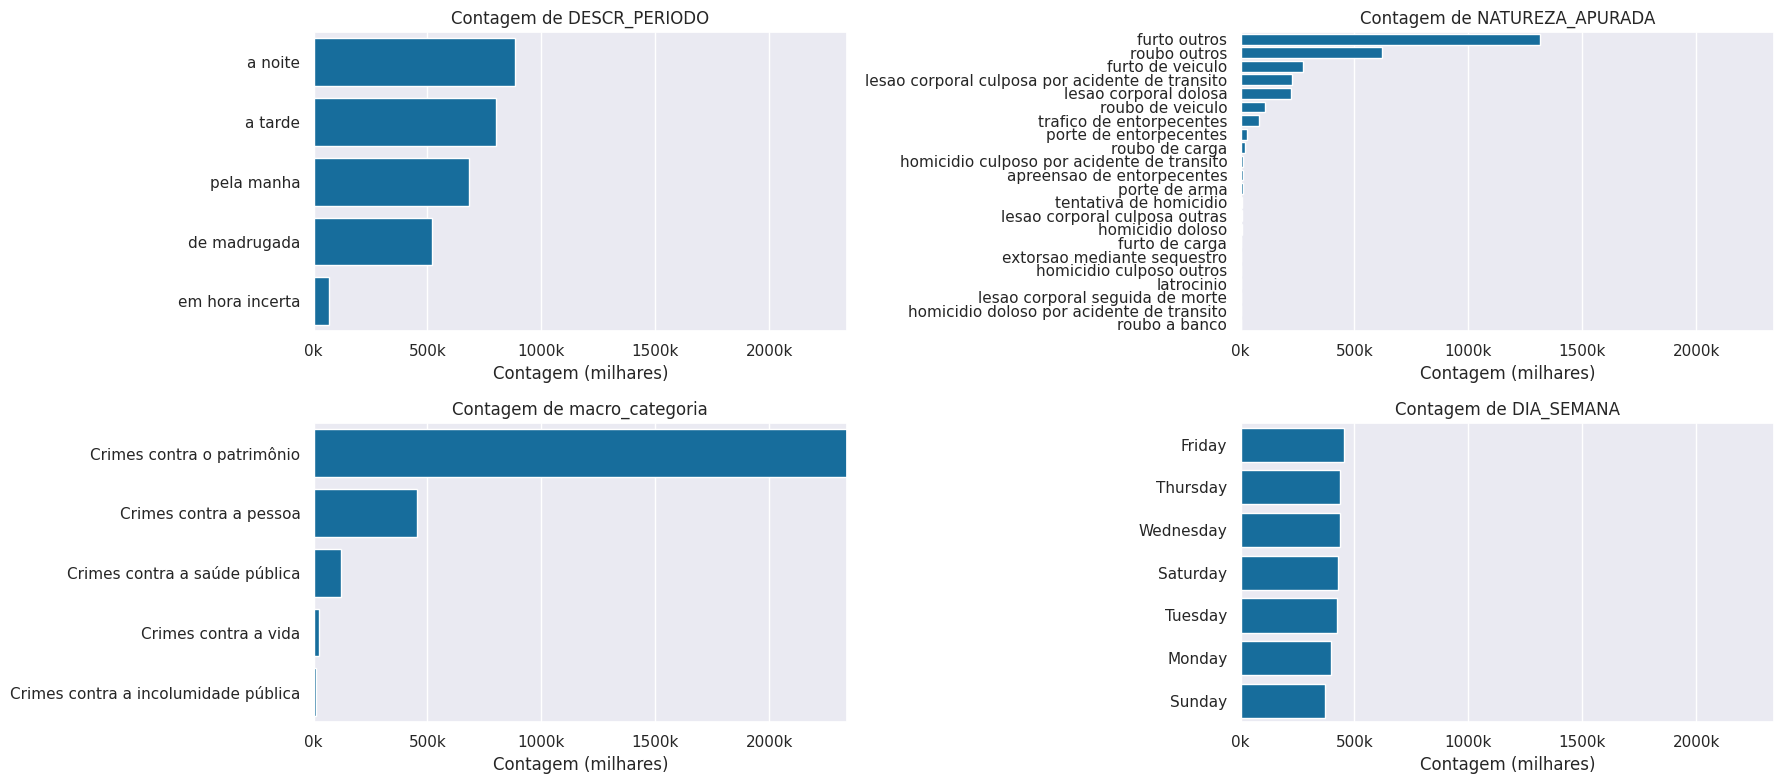

In [93]:
# Filtrar colunas com muitas categorias únicas para evitar plots ilegíveis e excluir as colunas de cidade
cols_to_plot = [col for col in text_cols if base_limpa[col].nunique() < 50 and col not in ['CIDADE', 'PERIODO_MES']]

# Definir o número de colunas para o grid
n_cols = 2
# Calcular o número de linhas necessário
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

# Criar a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten() # Achatar o array de eixos para facilitar a iteração

# Determinar o limite máximo para o eixo x em todos os plots
max_count = max(base_limpa[col].value_counts().max() for col in cols_to_plot)
x_limit_thousands = (max_count // 1000 + 1) * 1000 # Arredonda para o próximo milhar

# Gerar os countplots para cada coluna selecionada
for i, col in enumerate(cols_to_plot):
    sns.countplot(y=col, data=base_limpa, ax=axes[i], order=base_limpa[col].value_counts().index)
    axes[i].set_title(f'Contagem de {col}')
    axes[i].set_xlabel('Contagem (milhares)')
    axes[i].set_ylabel('')
    axes[i].set_xlim(0, x_limit_thousands) # Define o mesmo limite para o eixo x
    axes[i].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}k'.format(x/1000))) # Formata em milhares

# Remover subplots não utilizados
for j in range(len(cols_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Podemos ver uma concentração grande de crimes contra o patrimônio, o que está de acordo com os 3 crimes com maior registro no gráfico de natureza apurada. Já o período vemos que há uma distribuição mais igualitária.

Neste momento achei importante definirmos categorias com um pouco mais de granularidade para o modelo, não utilizaremos `NATUREZA_APURADA` por ser muito granular, nem `macro_categoria` por ser muito ampla (foi útil para definirmos o corte nos dados, mas para a clusterização pode ser ampla demais).

Por isso vamos criar mais uma variável: `CATEGORIA_NATUREZA`, que agrupa determinados aspectos dos dados:

* `estupro`: União entre `estupro` e `estupro de vulnerável` - neste momento não teremos essa categoria por termos retirado Crimes Contra a Dignidade Sexual
* `roubo`: União entre `roubo a banco`, `roubo de carga`, `roubo de veiculo`, `roubo outros` e `latrocinio`
* `furto`: União entre `furto de carga`, `furto de veiculo`, `furto outros`
* `homicidio doloso`: União entre `homicidio doloso por acidente de transito`, `homicidio doloso`, `tentativa de homicidio`
* `homicidio culposo`: União entre `homicidio culposo outros`, `homicidio culposo por acidente de transito`
* `lesao corporal`: União entre `lesao corporal culposa por acidente de transito`, `lesao corporal culposa outras`, `lesao corporal seguida de morte`, `lesao corporal dolosa`
* `entorpecentes`: União entre `apreensao de entorpecentes`, `porte de entorpecentes`, `trafico de entorpecentes`
Algumas naturezas não se associam especificamente, vamos mantê-las como estão:
* `extorsao mediante sequestro`
* `porte de arma`

In [94]:
# definindo o dicionário de categorização
categoria_natureza_map = {
    "estupro": "estupro", # não temos essa categoria agora, mas vamos manter no dicionário para análises futuras
    "estupro de vulneravel": "estupro",

    "roubo a banco": "roubo",
    "roubo de carga": "roubo",
    "roubo de veiculo": "roubo",
    "roubo outros": "roubo",
    "latrocinio": "roubo",

    "furto de carga": "furto",
    "furto de veiculo": "furto",
    "furto outros": "furto",

    "homicidio doloso": "homicidio doloso",
    "homicidio doloso por acidente de transito": "homicidio doloso",
    "tentativa de homicidio": "homicidio doloso",

    "homicidio culposo outros": "homicidio culposo",
    "homicidio culposo por acidente de transito": "homicidio culposo",

    "lesao corporal culposa por acidente de transito": "lesao corporal",
    "lesao corporal culposa outras": "lesao corporal",
    "lesao corporal seguida de morte": "lesao corporal",
    "lesao corporal dolosa": "lesao corporal",

    "apreensao de entorpecentes": "entorpecentes",
    "porte de entorpecentes": "entorpecentes",
    "trafico de entorpecentes": "entorpecentes",

    "extorsao mediante sequestro": "extorsao mediante sequestro",
    "porte de arma": "porte de arma"
}

In [95]:
# Criar a coluna CATEGORIA_NATUREZA na base_limpa usando o dicionário de mapeamento
base_limpa['CATEGORIA_NATUREZA'] = base_limpa['NATUREZA_APURADA'].map(categoria_natureza_map).fillna('tipos singulares')

base_limpa.head(3)

,LATITUDE,LONGITUDE,DESCR_PERIODO,CIDADE,NATUREZA_APURADA,macro_categoria,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA,REGISTRO_FORA_CIDADE,CATEGORIA_NATUREZA
0,-23.55,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0,furto
1,-23.56,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0,furto
2,-23.55,-46.63,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Tuesday,0,furto


/tmp/ipython-input-2657359583.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='CATEGORIA_NATUREZA', data=base_limpa, order=base_limpa['CATEGORIA_NATUREZA'].value_counts().index, palette='viridis')


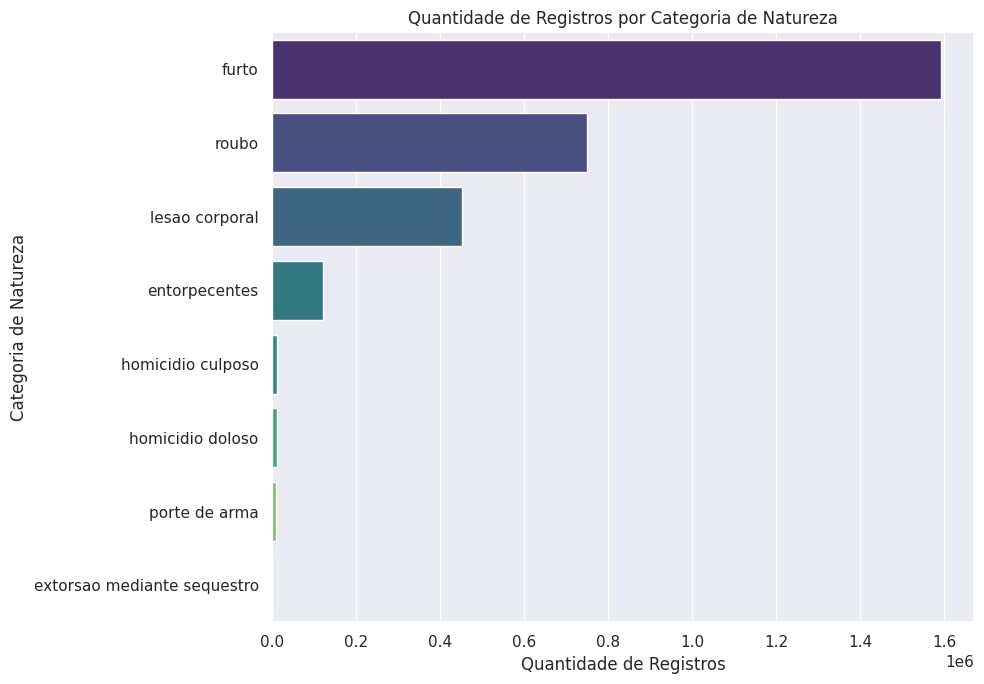

In [96]:
# Plotar a contagem de registros por CATEGORIA_NATUREZA
plt.figure(figsize=(10, 7))
sns.countplot(y='CATEGORIA_NATUREZA', data=base_limpa, order=base_limpa['CATEGORIA_NATUREZA'].value_counts().index, palette='viridis')
plt.title('Quantidade de Registros por Categoria de Natureza')
plt.xlabel('Quantidade de Registros')
plt.ylabel('Categoria de Natureza')
plt.tight_layout()
plt.show()

Agora vamos preparar os dados para o modelo.

## 4. Divisão Treino e Teste

Para definir os hotspots, precisaremos seguir uma série de definições e preparações. Para isso vamos separar os dados por tempo para treino e teste, depois vamos estruturar os passos em pipelines.

Vamos separar os dados por semestre e utilizar o sistema T e T+1, vamos treinar os registros com semestres dos anos iniciais e, para testar a aderência no T+1, vamos treinar o restante com os semestres mais próximos de 2025.

Para isso precisamos classificar os semestres e checar o volume de dados em cada um deles.

In [99]:
# criando a coluna de classificação do ano-semestre
# Extrair o ano e o mês de PERIODO_MES
base_limpa['ANO'] = base_limpa['PERIODO_MES'].str.split('-').str[0]
base_limpa['MES'] = base_limpa['PERIODO_MES'].str.split('-').str[1].astype(int)

# Definir o semestre com base no mês
base_limpa['SEMESTRE'] = base_limpa['MES'].apply(lambda x: 1 if 1 <= x <= 6 else 2)

# Combinar ano e semestre no formato YYYY-S
base_limpa['ANO_SEMESTRE'] = base_limpa['ANO'].astype(str) + '-S' + base_limpa['SEMESTRE'].astype(str)

# Remover colunas auxiliares temporárias (ANO, SEMESTRE)
base_limpa.drop(columns=['ANO', 'SEMESTRE'], inplace=True)

# Exibir as primeiras linhas para verificar a nova coluna
base_limpa.head(3)

,LATITUDE,LONGITUDE,DESCR_PERIODO,CIDADE,NATUREZA_APURADA,macro_categoria,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA,REGISTRO_FORA_CIDADE,CATEGORIA_NATUREZA,MES,ANO_SEMESTRE
0,-23.55,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0,furto,1,2022-S1
1,-23.56,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0,furto,1,2022-S1
2,-23.55,-46.63,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Tuesday,0,furto,1,2022-S1


Agora vamos checar a quantidade de registros por semestre.

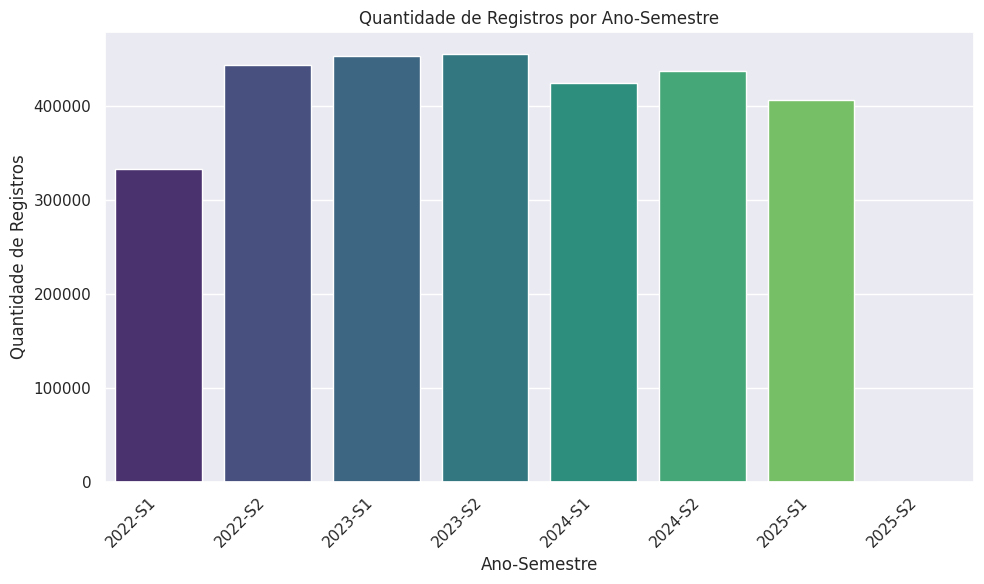

In [100]:
# Contar a quantidade de registros por ANO_SEMESTRE
semester_counts = base_limpa['ANO_SEMESTRE'].value_counts().sort_index()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=semester_counts.index, hue=semester_counts.index, y=semester_counts.values, palette='viridis', legend= False)
plt.title('Quantidade de Registros por Ano-Semestre')
plt.xlabel('Ano-Semestre')
plt.ylabel('Quantidade de Registros')
plt.xticks(rotation=45, ha='right') # Rotacionar os rótulos do eixo x para melhor legibilidade
plt.tight_layout()
plt.show()

Vamos utilizar os dados de 2022 a 2023 para treinar o modelo inicialmente e deixar os dados de 2024 e do primeiro semestre de 2025 para teste.

A partir de agora começamos o processamento em pipelines.

In [101]:
# definindo a df para o pipeline
df = base_limpa.copy()

df.shape

(2951282, 17)

In [102]:
# separando em treino e teste
semestres_treino = ["2022-S1", "2022-S2", "2023-S1", "2023-S2"]
semestre_teste = ["2024-S1", "2024-S2", "2025-S1"]

df_T = df[df['ANO_SEMESTRE'].isin(semestres_treino)]
df_T1 = df[df['ANO_SEMESTRE'].isin(semestre_teste)]

print(f"df_T shape: {df_T.shape}")
print(f"df_T1 shape: {df_T1.shape}")

df_T shape: (1684375, 17)
df_T1 shape: (1266902, 17)


A partir de agora vamos definir funções para cada passo do tratamento dos dados, para garantir que não haja vazamentos.

Para facilitar os próximos passos, vamos salvar as bases tratadas como parquet. Caso o processamento seja muito longo, pode-se pular toda essa etapa e seguir para o pré-processamento diretamente, evitando o processamento dos textos, que está demorando muito tempo.

In [103]:
# salvando como parquet
df_T.to_parquet("df_T.parquet", index=False, engine="pyarrow", compression="zstd")
df_T1.to_parquet("df_T1.parquet", index=False, engine="pyarrow", compression="zstd")

In [104]:
# baixando para subir tratado no github
files.download("df_T.parquet")
files.download("df_T1.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. Pipelines de Pré-Processamento (Pode Pular pra Cá depois da Etapa 1)

Para criação do modelo teremos que seguir uma série de etapas. Primeiro vamos ler o parquet de teste do github.


In [4]:
# lendo os parquets do github
url = "https://raw.githubusercontent.com/nathpignaton/criminalidade_sp/main/tratados/df_T.parquet"
df_T = pd.read_parquet(url, engine="pyarrow")

df_T.head(3)

,LATITUDE,LONGITUDE,DESCR_PERIODO,CIDADE,NATUREZA_APURADA,macro_categoria,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA,REGISTRO_FORA_CIDADE,CATEGORIA_NATUREZA,MES,ANO_SEMESTRE
0,-23.55,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0,furto,1,2022-S1
1,-23.56,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0,furto,1,2022-S1
2,-23.55,-46.63,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Tuesday,0,furto,1,2022-S1


Vamos criar uma função inicial para ajustar os tipos (que foram desajustados no parquet).

In [5]:
def ajustar_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()

    # Strings/objetos padronizados
    cols_str = [
        "DESCR_PERIODO","CIDADE","NATUREZA_APURADA","macro_categoria", "CATEGORIA_NATUREZA",
        "PERIODO_MES","DIA_SEMANA","ANO_SEMESTRE"
    ]
    for c in cols_str:
        if c in d.columns:
            d[c] = d[c].astype("string")

    # Floats (usar Float64 anulável do pandas) - Manter apenas colunas que devem ser float
    cols_float = [
        "AREA_TERRITORIAL", "DENSIDADE_DEMOGRAFICA","PIB_PER_CAPITA","LATITUDE","LONGITUDE"
    ]
    for c in cols_float:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce").astype("Float64")

    # Inteiros anuláveis (Incluindo LATITUDE, LONGITUDE e POPULACAO_CENSO, DIFERENCA_REGISTRO, REGISTRO_FORA_CIDADE)
    cols_int = [
        "POPULACAO_CENSO",
        "DIFERENCA_REGISTRO","REGISTRO_FORA_CIDADE"
    ]
    for c in cols_int:
         if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce").astype("Int64")


    return d

In [6]:
# aplicando na df_T
df_T = ajustar_dtypes(df_T)

df_T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684375 entries, 0 to 1684374
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   LATITUDE               1684375 non-null  Float64
 1   LONGITUDE              1684375 non-null  Float64
 2   DESCR_PERIODO          1684375 non-null  string 
 3   CIDADE                 1684375 non-null  string 
 4   NATUREZA_APURADA       1684375 non-null  string 
 5   macro_categoria        1684375 non-null  string 
 6   AREA_TERRITORIAL       1684375 non-null  Float64
 7   POPULACAO_CENSO        1684375 non-null  Int64  
 8   DENSIDADE_DEMOGRAFICA  1684375 non-null  Float64
 9   PIB_PER_CAPITA         1684375 non-null  Float64
 10  PERIODO_MES            1684375 non-null  string 
 11  DIFERENCA_REGISTRO     1684375 non-null  Int64  
 12  DIA_SEMANA             1684375 non-null  string 
 13  REGISTRO_FORA_CIDADE   1684375 non-null  Int64  
 14  CATEGORIA_NATUREZA

Agora vamos selecionar os features e prepará-los. Além de seleção das colunas, vamos realizar a divisão do database para clusterizar separado:
* Registros da cidade de São Paulo - `df_spaulo` - pelo gigantesco volume de ocorrências e características da cidade, é um outlier e será clusterizada separada
* Registros no restante do estado - `df_sp`

Vamos transformar a `df_sp` em uma df agrupada por `CIDADE`, para agrupar as cidades similares no estado.

In [7]:
# separando df_spaulo e df_sp
df_spaulo = df_T[df_T["CIDADE"] == "sao paulo"].copy()
df_sp = df_T[df_T["CIDADE"] != "sao paulo"].copy()

print(f"Tamanh df cidade São Paulo: {df_spaulo.shape[0]}\nTamanh df restante do estado: {df_sp.shape[0]}")

Tamanh df cidade São Paulo: 749028
Tamanh df restante do estado: 935347


### 5.1 Criando o modelo

In [8]:
# imprimindo as colunas para selecionar
df_sp.columns

Index(['LATITUDE', 'LONGITUDE', 'DESCR_PERIODO', 'CIDADE', 'NATUREZA_APURADA',
       'macro_categoria', 'AREA_TERRITORIAL', 'POPULACAO_CENSO',
       'DENSIDADE_DEMOGRAFICA', 'PIB_PER_CAPITA', 'PERIODO_MES',
       'DIFERENCA_REGISTRO', 'DIA_SEMANA', 'REGISTRO_FORA_CIDADE',
       'CATEGORIA_NATUREZA', 'MES', 'ANO_SEMESTRE'],
      dtype='object')

In [9]:
# selecionando as features que preparamos, deixando uma quantidade pequena para facilitar o treino do modelo
cat_cols = ["DIA_SEMANA","DESCR_PERIODO", "CATEGORIA_NATUREZA", "MES"] # categoria_natureza traz a informação de natureza_apurada com um pouco menos de granularidade
num_cols = ["PIB_PER_CAPITA","DENSIDADE_DEMOGRAFICA"] # não vamos incluir nem populacao_censo nem area_territorial, já que os dois estao em densidade_demografica

Não foi possível utilizar o parâmetro `CIDADE` no modelo, a RAM do notebook não comportou.

In [10]:
# transformando as categóricas
df_cat = pd.get_dummies(df_sp[cat_cols].astype("string"), drop_first=True)
X_num = StandardScaler().fit_transform(df_sp[num_cols].values)

# consolidando
X = np.hstack([X_num, df_cat.values])

Agora que preparamos os features, vamos treinar o modelo.

In [11]:
mbk = MiniBatchKMeans(n_clusters=5, random_state=CONFIG["random_seed"], batch_size=4096, max_iter=100)
labels_mbk = mbk.fit_predict(X)

Como o tempo de processamento está alto demais pelo volume de registros, vamos calcular as métricas por amostragem. As métricas internas foram estimadas via amostragem estratificada por cluster, 2.000 amostras por cluster, 5 repetições. Reportamos média e desvio padrão. O procedimento mantém a representatividade e reduz o custo computacional sem alterar conclusões.

In [12]:
def metricas_por_amostra(X, labels, por_cluster=3000, reps=3, seed=CONFIG['random_seed']):
    rng = np.random.default_rng(seed)
    sils, dbs = [], []
    clusters = np.unique(labels)
    idx_por_cluster = {c: np.where(labels==c)[0] for c in clusters}
    for _ in range(reps):
        amostra = []
        for c in clusters:
            idx_c = idx_por_cluster[c]
            n = min(por_cluster, len(idx_c))
            amostra.append(rng.choice(idx_c, size=n, replace=False))
        amostra = np.concatenate(amostra)
        sils.append(silhouette_score(X[amostra], labels[amostra]))
        dbs.append(davies_bouldin_score(X[amostra], labels[amostra]))
    return {
        "silhouette_media": float(np.mean(sils)),
        "silhouette_dp": float(np.std(sils)),
        "db_media": float(np.mean(dbs)),
        "db_dp": float(np.std(dbs)),
        "amostra_total": int(len(amostra))
    }

In [13]:
res = metricas_por_amostra(X, labels_mbk, por_cluster=2000, reps=5)
res

{'silhouette_media': 0.17765715673753155,
 'silhouette_dp': 0.0005484904866943112,
 'db_media': 2.1059406860873673,
 'db_dp': 0.004349215405614006,
 'amostra_total': 10000}

In [14]:
vals, cnts = np.unique(labels_mbk, return_counts=True)
list(zip(vals, cnts))

[(np.int32(0), np.int64(159305)),
 (np.int32(1), np.int64(503818)),
 (np.int32(2), np.int64(169843)),
 (np.int32(3), np.int64(76756)),
 (np.int32(4), np.int64(25625))]

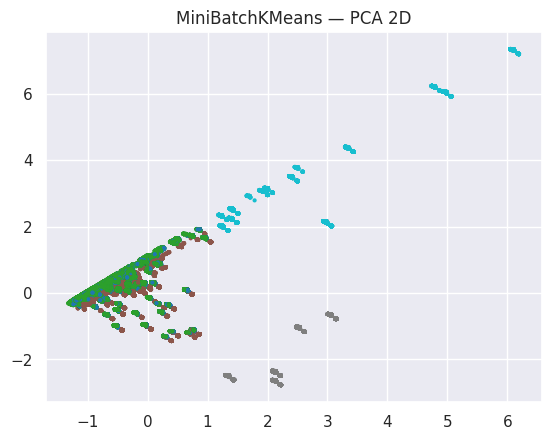

In [15]:
pca_vis = PCA(n_components=2, random_state=CONFIG["random_seed"])
X2 = pca_vis.fit_transform(X)

plt.scatter(X2[:,0], X2[:,1], c=labels_mbk, s=4, cmap="tab10")
plt.title("MiniBatchKMeans — PCA 2D")
plt.show()

Para calcular outros tamanhos de cluster, vamos ver o famoso gráfico do cotovelo.

In [35]:
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # ajuste se quiser
inertias = []

for k in ks:
    mbk = MiniBatchKMeans(
        n_clusters=k,
        random_state=CONFIG["random_seed"],
        batch_size=4096,
        max_iter=100
    )
    mbk.fit(X)
    inertias.append(mbk.inertia_)

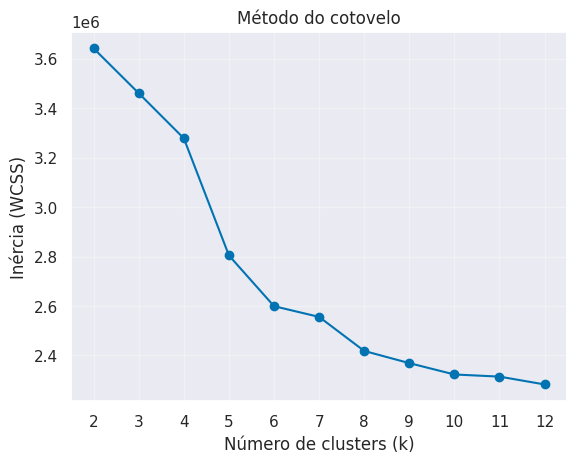

In [36]:
plt.plot(ks, inertias, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inércia (WCSS)")
plt.title("Método do cotovelo")
plt.xticks(ks)
plt.grid(True, alpha=0.3)
plt.show()

O gráfico se mostrou inconclusivo, por isso vamos avaliar através de outros indicadores.

Cluster Evaluation Metrics:


,k,Silhouette Score (Mean),Davies-Bouldin Score (Mean)
0,2,0.16,2.01
1,3,0.12,2.39
2,4,0.18,1.96
3,5,0.16,2.29
4,6,0.17,2.03
5,7,0.15,2.36
6,8,0.15,2.23
7,9,0.17,2.08
8,10,0.15,2.21


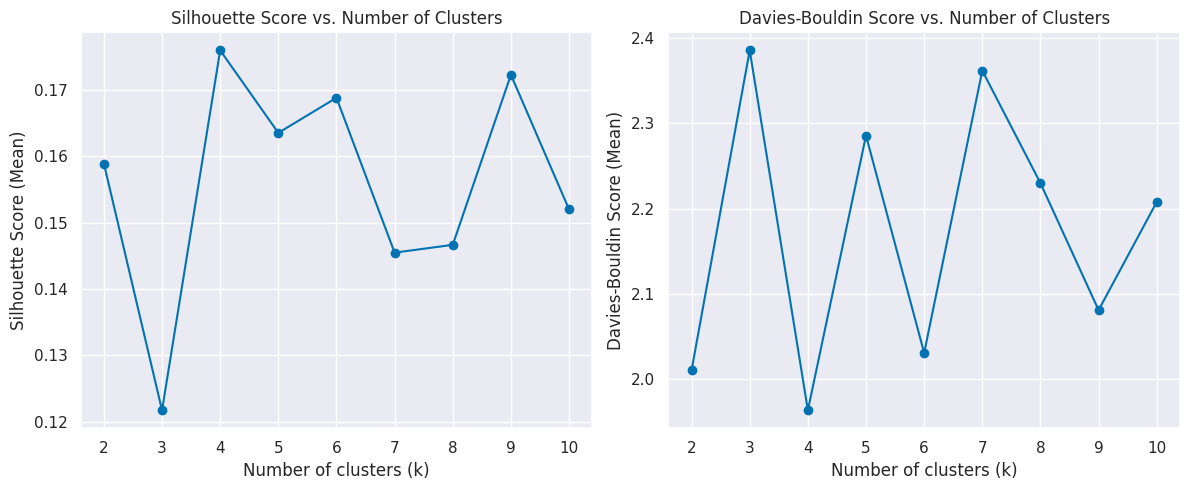

In [37]:
ks = range(2, 11)
silhouette_scores = []
davies_bouldin_scores = []

for k in ks:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=CONFIG["random_seed"], batch_size=4096, max_iter=100, n_init=10) # Added n_init for robustness
    mbk.fit(X)
    labels_mbk = mbk.predict(X)

    res = metricas_por_amostra(X, labels_mbk, por_cluster=2000, reps=5)

    silhouette_scores.append(res['silhouette_media'])
    davies_bouldin_scores.append(res['db_media'])

evaluation_df = pd.DataFrame({'k': ks, 'Silhouette Score (Mean)': silhouette_scores, 'Davies-Bouldin Score (Mean)': davies_bouldin_scores})
print("Cluster Evaluation Metrics:")
display(evaluation_df)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ks, silhouette_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score (Mean)')
plt.title('Silhouette Score vs. Número de Clusters')
plt.xticks(ks)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ks, davies_bouldin_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Davies-Bouldin Score (Mean)')
plt.title('Davies-Bouldin Score vs. Número de Clusters')
plt.xticks(ks)
plt.grid(True)

plt.tight_layout()
plt.show()

Interpretando os índices observamos que os melhores clusters com base no Silhouette Score foram 4, 9 ou 6 clusters. No caso do score Davies-Bouldin, vemos quase os mesmos 3 ks: 4, seguido de 2 e 6.
Por isso vamos escolher 4 clusters.

In [45]:
melhor_valor_clusters = 6 # testamos com 4, mas foi pior que o GMM
mbk = MiniBatchKMeans(n_clusters=melhor_valor_clusters, random_state=CONFIG["random_seed"], batch_size=4096, max_iter=100)
labels_mbk = mbk.fit_predict(X)

In [46]:
res_k6 = metricas_por_amostra(X, labels_mbk, por_cluster=2000, reps=5)
res_k6

{'silhouette_media': 0.16899158385026375,
 'silhouette_dp': 0.000521192039899955,
 'db_media': 2.030938527109488,
 'db_dp': 0.0030448474832110643,
 'amostra_total': 12000}

Em linha geral, o modelo separa os dados, mas as fronteiras entre os grupos não são muito nítidas: a silhouette média ficou em torno de 0,16 e o Davies–Bouldin em ~2,03, ambos com variação bem baixa na amostra, o que indica estabilidade, mas separação moderada.

Como baseline, é aceitável e útil para uma primeira leitura dos padrões; porém, para ganhar mais contraste entre clusters, vamos testar modelos alternativos e checar a diferença entre os resultados.

Criando um comparativo com GaussianMixture (GMM).

In [40]:
ks = [2, 3, 4, 7]
bics, modelos = [], {}

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type="diag", tol=1e-3,
                          max_iter=200, random_state=CONFIG["random_seed"])
    gmm.fit(X)
    bics.append(gmm.bic(X))
    modelos[k] = gmm

list(zip(ks, bics))
k_bic = ks[int(np.argmin(bics))]
k_bic

7

In [41]:
gmm = modelos[k_bic]
labels_gmm = gmm.predict(X)

# amostra estratificada
rng = np.random.default_rng(CONFIG['random_seed'])
idxs = []
for c in np.unique(labels_gmm):
    idx_c = np.where(labels_gmm == c)[0]
    n = min(2000, len(idx_c))
    idxs.append(rng.choice(idx_c, size=n, replace=False))
idxs = np.concatenate(idxs)

sil_gmm = silhouette_score(X[idxs], labels_gmm[idxs])
db_gmm  = davies_bouldin_score(X[idxs], labels_gmm[idxs])
sil_gmm, db_gmm

(np.float64(0.03555611140717764), np.float64(2.929890646132502))

In [42]:
print(f"Silhouette médio GMM: {sil_gmm:.4f}")
print(f"Davies-Bouldin médio GMM: {db_gmm:.4f}")

Silhouette médio GMM: 0.0356
Davies-Bouldin médio GMM: 2.9299


In [47]:
# comparando com kmeans
res_k6

{'silhouette_media': 0.16899158385026375,
 'silhouette_dp': 0.000521192039899955,
 'db_media': 2.030938527109488,
 'db_dp': 0.0030448474832110643,
 'amostra_total': 12000}

Os resultados ainda não estão nada bons, a silhouette média está bem distante de 1 e davies-bouldin de 2,03 está longe do ideal. Mas vamos seguir com a análise como está.

Vamos checar a separação dos dados nos clusters nos dois modelos.

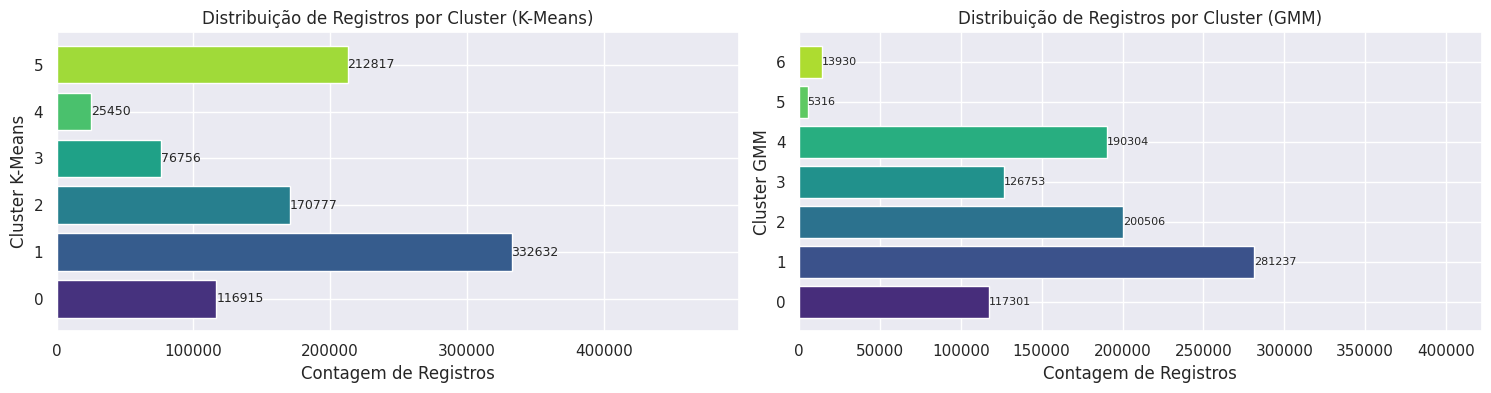

In [48]:
vals_gmm, cnts_gmm = np.unique(labels_gmm, return_counts=True)
vals_k, cnts_k = np.unique(labels_mbk, return_counts=True)


# Reduzir o tamanho da fonte globalmente para este plot
plt.rcParams.update({'font.size': 9}) # Tamanho da fonte ajustável

# Criar a figura e os subplots (1 linha, 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) # Ajuste o tamanho da figura conforme necessário

# Plotar o gráfico de barras horizontais no primeiro subplot (axes[0])
bars = axes[0].barh(range(len(vals_k)), cnts_k, color=sns.color_palette('viridis', len(vals_k)))

# Adicionar rótulos e título ao primeiro subplot
axes[0].set_xlabel("Contagem de Registros")
axes[0].set_ylabel("Cluster K-Means")
axes[0].set_title("Distribuição de Registros por Cluster (K-Means)")
axes[0].set_yticks(range(len(vals_k))) # Definir os ticks do eixo y
axes[0].set_yticklabels(vals_k) # Definir os rótulos do eixo y como os valores dos clusters

# Definir o range do eixo x manualmente (exemplo: 0 até a contagem máxima + uma margem)
max_count = max(cnts_k)
axes[0].set_xlim(0, max_count * 1.5) # Adiciona 10% de margem no limite superior

# Adicionar os valores de contagem dentro das barras
for bar in bars:
    width = bar.get_width()
    axes[0].text(width, bar.get_y() + bar.get_height()/2, f'{width}', va='center', ha='left', fontsize=9) # Fonte menor para o texto dentro da barra

# Plotar o gráfico de barras horizontais no segundo subplot (axes[0])
bars = axes[1].barh(range(len(vals_gmm)), cnts_gmm, color=sns.color_palette('viridis', len(vals_gmm)))

# Adicionar rótulos e título ao primeiro subplot
axes[1].set_xlabel("Contagem de Registros")
axes[1].set_ylabel("Cluster GMM")
axes[1].set_title("Distribuição de Registros por Cluster (GMM)")
axes[1].set_yticks(range(len(vals_gmm))) # Definir os ticks do eixo y
axes[1].set_yticklabels(vals_gmm) # Definir os rótulos do eixo y como os valores dos clusters

# Definir o range do eixo x manualmente (exemplo: 0 até a contagem máxima + uma margem)
max_count = max(cnts_gmm)
axes[1].set_xlim(0, max_count * 1.5) # Adiciona 10% de margem no limite superior

# Adicionar os valores de contagem dentro das barras
for bar in bars:
    width = bar.get_width()
    axes[1].text(width, bar.get_y() + bar.get_height()/2, f'{width}', va='center', ha='left', fontsize=8) # Fonte menor para o texto dentro da barra


plt.tight_layout()
plt.show()

# Resetar o tamanho da fonte para o padrão após este plot (opcional)
plt.rcParams.update({'font.size': plt.rcParamsDefault['font.size']})

Com 4 categorias, pudemos observar que K-Means apresentou resultados aparentemente piores que o modelo GMM, que parece ter alguma sobreposição e pesos desbalanceados entre as categorias. Como com 4 categorias tivemos esses problemas, recalculamos para 6 clusters, como no modelo GMM (e o segundo da análise sillhouette).

Com 6 clusters, observamos a diferença de distribuição em algumas categorias.

Por isso vamos utilizar esses parâmetros para treinar, também, a base de T+1 e ver os resultados, clusterizar os boletins para a cidade de São Paulo será uma melhoria futura neste trabalho.

Agora vamos checar as características dos clusters criados, antes de seguir para a clusterização do T+1.

In [49]:
df_km = df_sp.copy()
df_km["cluster_mbk"] = labels_mbk
df_km.head()

,LATITUDE,LONGITUDE,DESCR_PERIODO,CIDADE,NATUREZA_APURADA,macro_categoria,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA,REGISTRO_FORA_CIDADE,CATEGORIA_NATUREZA,MES,ANO_SEMESTRE,cluster_mbk
19840,-22.68,-44.32,de madrugada,bananal,lesao corporal dolosa,Crimes contra a pessoa,616.43,9969,16.17,19568.66,2022-01,0,Sunday,0,lesao corporal,1,2022-S1,5
19841,-22.68,-44.32,de madrugada,bananal,lesao corporal dolosa,Crimes contra a pessoa,616.43,9969,16.17,19568.66,2022-01,0,Sunday,0,lesao corporal,1,2022-S1,5
19842,-22.57,-44.96,pela manha,cruzeiro,furto outros,Crimes contra o patrimônio,305.70,74961,245.21,38390.41,2022-01,0,Monday,0,furto,1,2022-S1,0
19843,-22.58,-44.96,de madrugada,cruzeiro,furto outros,Crimes contra o patrimônio,305.70,74961,245.21,38390.41,2022-01,0,Thursday,0,furto,1,2022-S1,1
19844,-22.58,-44.96,pela manha,cruzeiro,furto outros,Crimes contra o patrimônio,305.70,74961,245.21,38390.41,2022-01,0,Tuesday,0,furto,1,2022-S1,0


### 5.2 Descrevendo os perfis dos clusters

Primeiro vamos checar a questão da periodicidade, ver se tem clusters com um números maior de ocorrências em determinado mês ou ano.

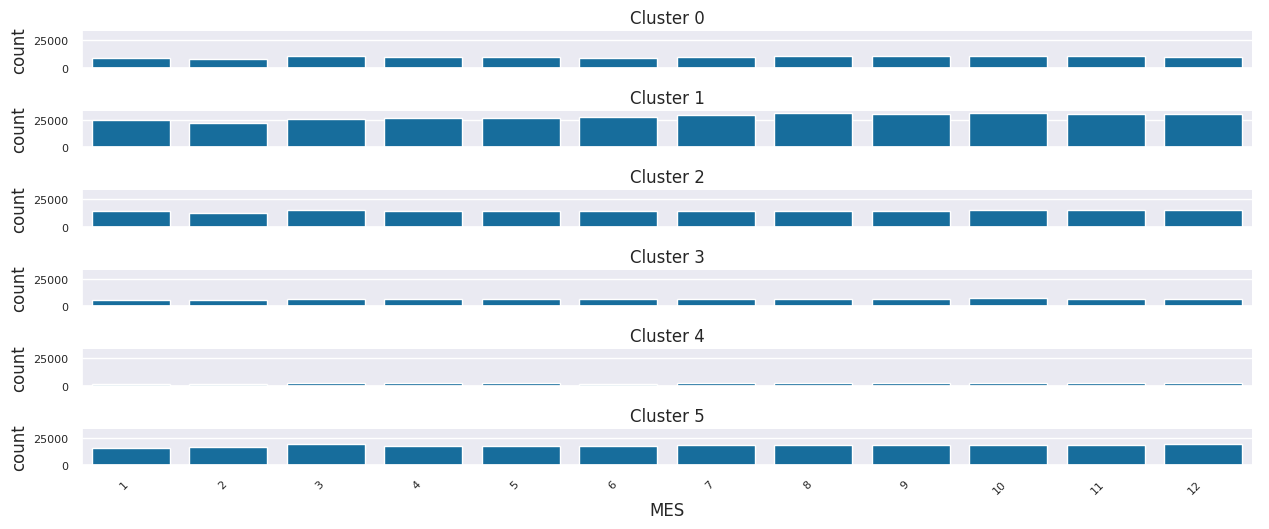

In [50]:
# pegando a contagem de registros por cluster e periodo
cluster_period_counts = df_km.groupby(['cluster_mbk', 'MES']).size().reset_index(name='count')

# definindo a ordem dos periodos para plotagem
period_order = sorted(cluster_period_counts['MES'].unique())

# ordenar os dados por periodo para garantir a ordem correta no grafico
cluster_period_counts['MES'] = pd.Categorical(cluster_period_counts['MES'], categories=period_order, ordered=True)
cluster_period_counts = cluster_period_counts.sort_values('MES')

# Criar um catplot para visualizar a distribuicao dos clusters ao longo do tempo
g = sns.catplot(
    data=cluster_period_counts,
    x='MES',
    y='count',
    col='cluster_mbk',
    col_wrap=1,
    kind='bar',
    height=0.9,
    aspect=14,
    sharey=True,
    col_order=sorted(cluster_period_counts['cluster_mbk'].unique()),
)

# Rotacionar os rotulos do eixo x para melhor legibilidade
g.set_xticklabels(rotation=45, ha="right", fontsize=8) # Tamanho da fonte reduzido
g.set_titles("Cluster {col_name}", fontsize=9) # Reduzir o tamanho da fonte do titulo

# Define formatted_period_labels based on period_order
formatted_period_labels = [str(p) for p in period_order]

# Padronizar os limites e ticks do eixo x para todos os subplots
for ax in g.axes.flat:
    ax.set_xlim(-0.5, len(period_order) - 0.5)
    ax.set_xticks(range(len(period_order)))
    ax.set_xticklabels(formatted_period_labels, ha="right", fontsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()

plt.show()

Observando por esse ponto de vista, vemos que não há muito padrão de temporalidade nos clusters, com os clusters 1 e 5 concentrando o maior volume de registros, mas com baixa flutuação mês a mês.

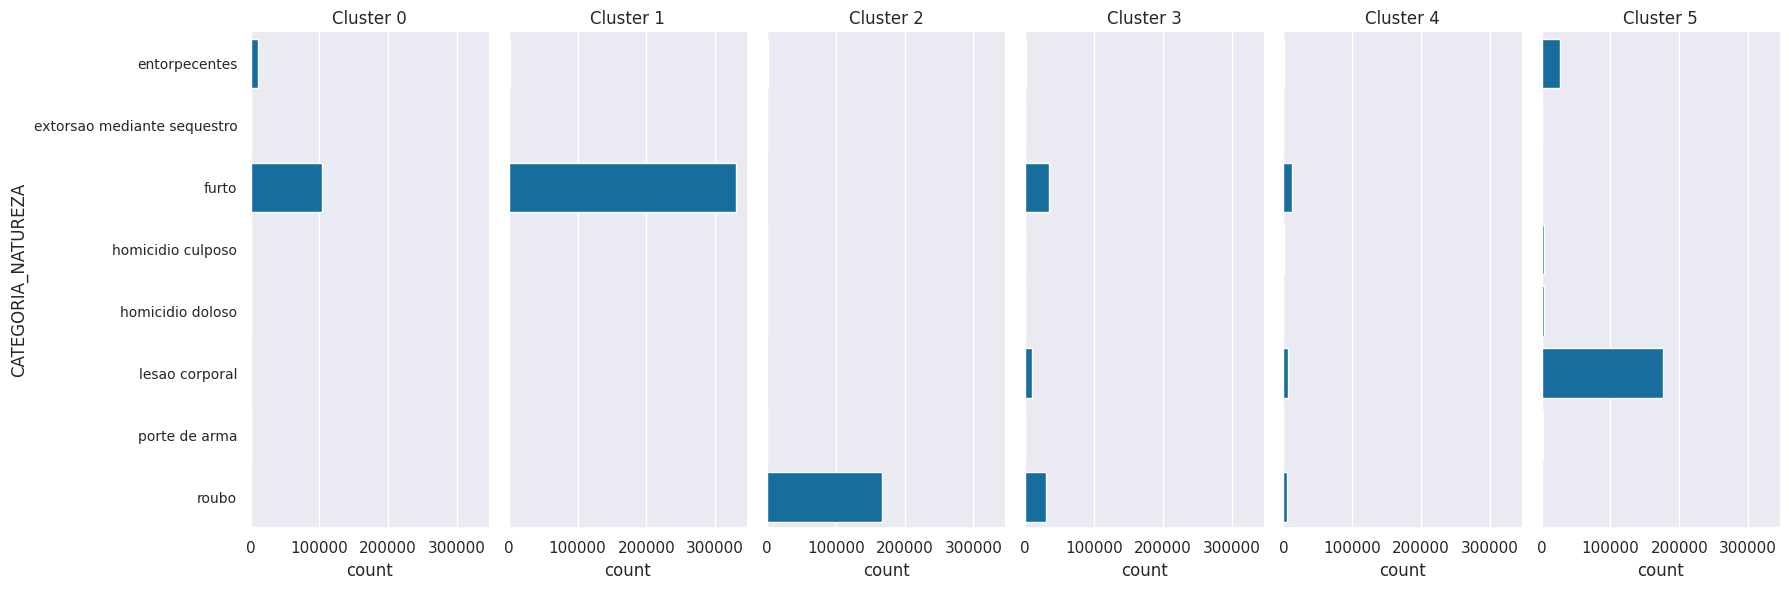

In [51]:
# pegando a contagem de categorias por cluster
cluster_category_counts = df_km.groupby(['cluster_mbk', 'CATEGORIA_NATUREZA']).size().reset_index(name='count')

# definindo a ordem das categorias para o eixo y (opcional, mas útil para consistência)
category_order = sorted(cluster_category_counts['CATEGORIA_NATUREZA'].unique())

# Create a FacetGrid
g = sns.FacetGrid(
    cluster_category_counts,
    col='cluster_mbk',
    col_wrap=6,
    height=6,
    aspect=0.5,
    col_order=sorted(cluster_category_counts['cluster_mbk'].unique()),
    sharey=True
)

g.map(sns.barplot, 'count', 'CATEGORIA_NATUREZA', order=category_order)

for i, ax in enumerate(g.axes.flat):
    if i > 0:
        ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=10)

# Set titles for each subplot
g.set_titles("Cluster {col_name}")

plt.tight_layout()
plt.show()

Aqui podemos observar que os clusters começam a se diferenciar:
* `Cluster 0` - Percebemos a presença maior de `entorpecentes` e `furto`
* `Cluster 1` - Percebemos a presença intensa de `furto`
* `Cluster 2`- Percebemos a presença maior de `roubo`
* `Cluster 3` - Percebemos aqui um volume de `furto`, `lesao corporal`, e `roubo`
* `Cluster 4` - Percebemos aqui as mesmas categorias do Cluster 3: `furto`, `lesao corporal`, e `roubo`, com um volume um pouco menor
* `Cluster 5` - Aqui vemos alta presença de `lesao corporal`, com `entorpecentes`, `homicidio culpuso` e `homicidio doloso`.

In [52]:
df_km.head(3)

,LATITUDE,LONGITUDE,DESCR_PERIODO,CIDADE,NATUREZA_APURADA,macro_categoria,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA,REGISTRO_FORA_CIDADE,CATEGORIA_NATUREZA,MES,ANO_SEMESTRE,cluster_mbk
19840,-22.68,-44.32,de madrugada,bananal,lesao corporal dolosa,Crimes contra a pessoa,616.43,9969,16.17,19568.66,2022-01,0,Sunday,0,lesao corporal,1,2022-S1,5
19841,-22.68,-44.32,de madrugada,bananal,lesao corporal dolosa,Crimes contra a pessoa,616.43,9969,16.17,19568.66,2022-01,0,Sunday,0,lesao corporal,1,2022-S1,5
19842,-22.57,-44.96,pela manha,cruzeiro,furto outros,Crimes contra o patrimônio,305.70,74961,245.21,38390.41,2022-01,0,Monday,0,furto,1,2022-S1,0


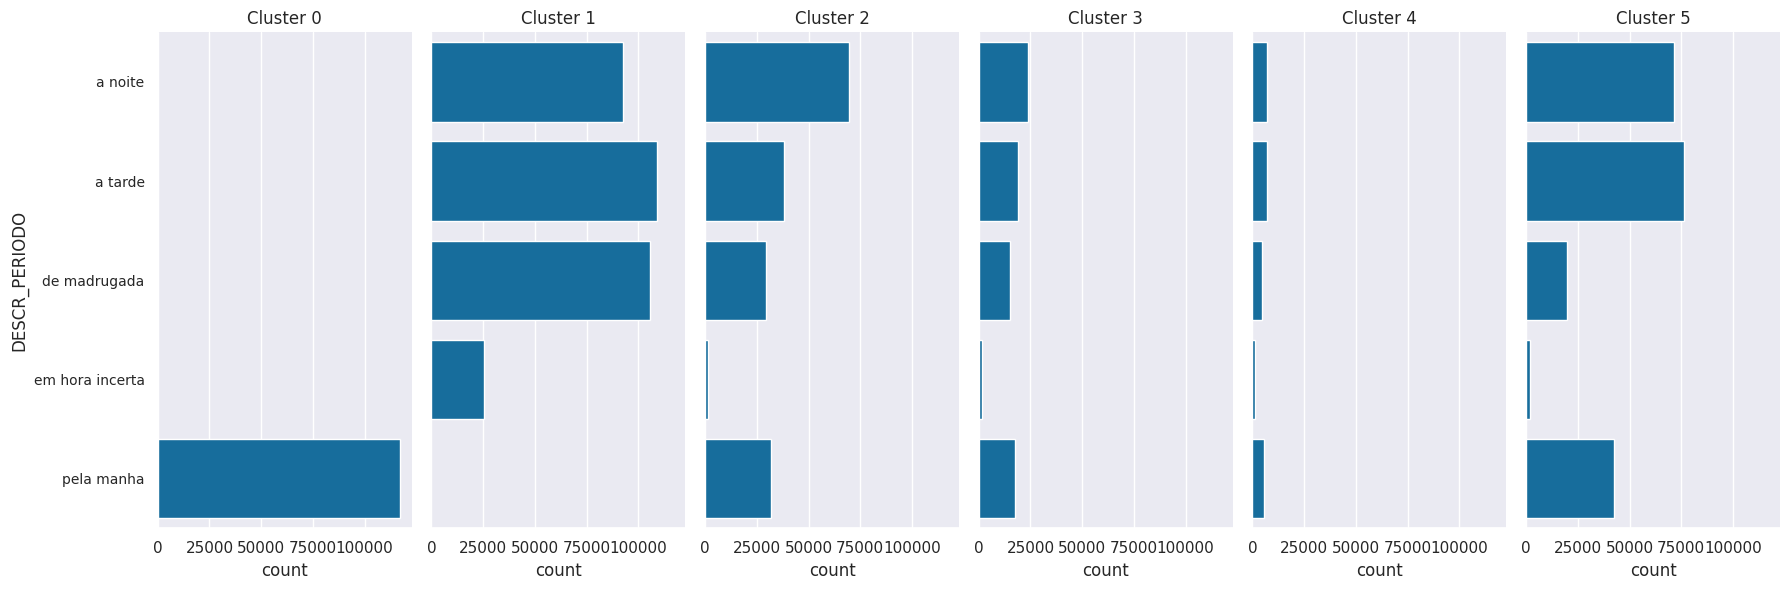

In [55]:
# pegando a contagem de categorias por cluster
cluster_category_counts = df_km.groupby(['cluster_mbk', 'DESCR_PERIODO']).size().reset_index(name='count')

# definindo a ordem das categorias para o eixo y (opcional, mas útil para consistência)
category_order = sorted(cluster_category_counts['DESCR_PERIODO'].unique())

# Create a FacetGrid
g = sns.FacetGrid(
    cluster_category_counts,
    col='cluster_mbk',
    col_wrap=6,
    height=6,
    aspect=0.5,
    col_order=sorted(cluster_category_counts['cluster_mbk'].unique()),
    sharey=True
)

g.map(sns.barplot, 'count', 'DESCR_PERIODO', order=category_order)

for i, ax in enumerate(g.axes.flat):
    if i > 0:
        ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=10)

# Set titles for each subplot
g.set_titles("Cluster {col_name}")

plt.tight_layout()
plt.show()

Aqui vemos que o modelo concentrou os crimes `pela manha` no Cluster 0, o Cluster 1 tem crimes em todos os outros momentos, menos nesse, e o restante dos clusters possuem todos os períodos do dia. O modelo não pareceu dividir muito bem.

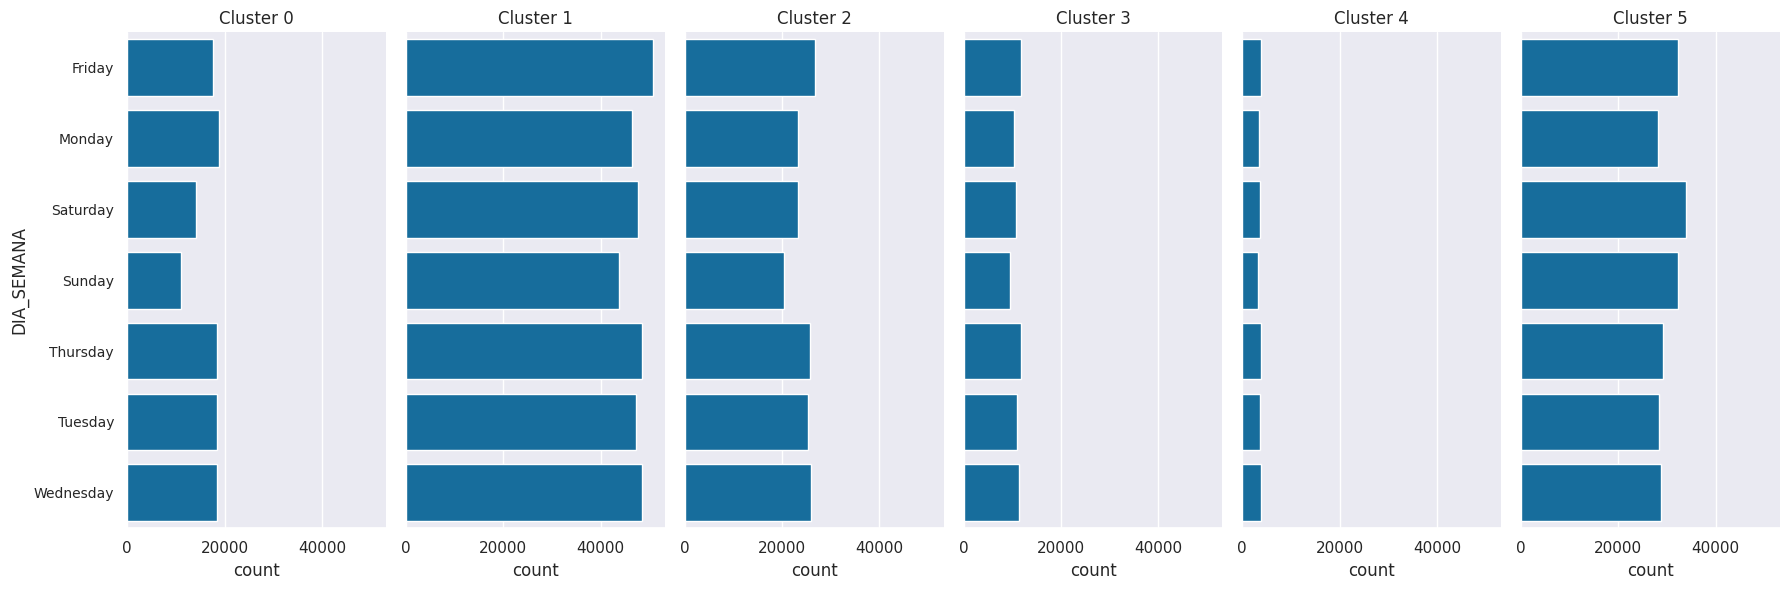

In [56]:
# pegando a contagem de categorias por cluster
cluster_category_counts = df_km.groupby(['cluster_mbk', 'DIA_SEMANA']).size().reset_index(name='count')

# definindo a ordem das categorias para o eixo y (opcional, mas útil para consistência)
category_order = sorted(cluster_category_counts['DIA_SEMANA'].unique())

# Create a FacetGrid
g = sns.FacetGrid(
    cluster_category_counts,
    col='cluster_mbk',
    col_wrap=6,
    height=6,
    aspect=0.5,
    col_order=sorted(cluster_category_counts['cluster_mbk'].unique()),
    sharey=True
)

g.map(sns.barplot, 'count', 'DIA_SEMANA', order=category_order)

for i, ax in enumerate(g.axes.flat):
    if i > 0:
        ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=10)

# Set titles for each subplot
g.set_titles("Cluster {col_name}")

plt.tight_layout()
plt.show()

Aqui novamente o modelo não separou com tanta clareza por dia da semana.

Agora vamos olhar as variáveis numéricas.

In [53]:
# médias, medianas e dispersão
cols_num = ["PIB_PER_CAPITA","DENSIDADE_DEMOGRAFICA"]
resumo_num = (
    df_km.groupby("cluster_mbk")[cols_num]
         .agg(["mean","median","std","min","max"])
)

resumo_num

PIB_PER_CAPITA                                         \
                      mean    median      std       min       max   
cluster_mbk                                                         
0                 50191.61  49692.93 20258.61   9468.33 154054.53   
1                 49607.18  49692.93 19701.86   9468.33 139885.74   
2                 48884.65  50495.56 19558.50   9964.11 139885.74   
3                 72895.59  43031.91 43835.34  16909.54 122765.64   
4                243600.58 207460.98 94559.52 154054.53 457517.70   
5                 47616.89  44679.93 19932.48   9468.33 154054.53   

            DENSIDADE_DEMOGRAFICA                                     
                             mean   median     std      min      max  
cluster_mbk                                                           
0                         1486.25  1027.87 1594.06     3.51  6765.14  
1                         1421.61  1027.87 1550.61     3.51  6765.14  
2                         2286.53  1979.65 1794.58     5.60  6765.14  
3                        11823.16 11217.40  900.07 10805.23 13416.81  
4                         1975.11   796.51 1998.55    13.90  4816.87  
5                          838.80   307.19 1211.27     3.51  6765.14

Aqui podemos ver que talvez o modelo tenha ficado desbalanceado pelos valores de PIB_PER_CAPITA e DENSIDADE_DEMOGRAFICA das cidades. Essa pode ser uma melhoria desse trabalho.

Agora vamos realizar a mesma clusterização para os dados T+1.

### 5.3 Treinando para T+1 & Verificando os perfis

In [57]:
# lendo os parquets do github
url = "https://raw.githubusercontent.com/nathpignaton/criminalidade_sp/main/tratados/df_T.parquet"
df_T1 = pd.read_parquet(url, engine="pyarrow")

df_T1.head(3)

,LATITUDE,LONGITUDE,DESCR_PERIODO,CIDADE,NATUREZA_APURADA,macro_categoria,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA,REGISTRO_FORA_CIDADE,CATEGORIA_NATUREZA,MES,ANO_SEMESTRE
0,-23.55,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0,furto,1,2022-S1
1,-23.56,-46.63,a tarde,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Monday,0,furto,1,2022-S1
2,-23.55,-46.63,pela manha,sao paulo,furto outros,Crimes contra o patrimônio,1521.20,11451999,7528.26,66872.84,2022-01,0,Tuesday,0,furto,1,2022-S1


In [58]:
# aplicando na df_T
df_T1 = ajustar_dtypes(df_T1)

df_T1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684375 entries, 0 to 1684374
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   LATITUDE               1684375 non-null  Float64
 1   LONGITUDE              1684375 non-null  Float64
 2   DESCR_PERIODO          1684375 non-null  string 
 3   CIDADE                 1684375 non-null  string 
 4   NATUREZA_APURADA       1684375 non-null  string 
 5   macro_categoria        1684375 non-null  string 
 6   AREA_TERRITORIAL       1684375 non-null  Float64
 7   POPULACAO_CENSO        1684375 non-null  Int64  
 8   DENSIDADE_DEMOGRAFICA  1684375 non-null  Float64
 9   PIB_PER_CAPITA         1684375 non-null  Float64
 10  PERIODO_MES            1684375 non-null  string 
 11  DIFERENCA_REGISTRO     1684375 non-null  Int64  
 12  DIA_SEMANA             1684375 non-null  string 
 13  REGISTRO_FORA_CIDADE   1684375 non-null  Int64  
 14  CATEGORIA_NATUREZA

In [59]:
# separando df_spaulo e df_sp
df_spaulo1 = df_T1[df_T1["CIDADE"] == "sao paulo"].copy()
df_sp1 = df_T1[df_T1["CIDADE"] != "sao paulo"].copy()

print(f"Tamanh df cidade São Paulo: {df_spaulo1.shape[0]}\nTamanh df restante do estado: {df_sp1.shape[0]}")

Tamanh df cidade São Paulo: 749028
Tamanh df restante do estado: 935347


In [60]:
# transformando as categóricas
df_cat = pd.get_dummies(df_sp1[cat_cols].astype("string"), drop_first=True)
X_num = StandardScaler().fit_transform(df_sp1[num_cols].values)

# consolidando
X1 = np.hstack([X_num, df_cat.values])

In [62]:
mbk = MiniBatchKMeans(n_clusters=6, random_state=CONFIG["random_seed"], batch_size=4096, max_iter=100)
labels_mbk = mbk.fit_predict(X1)

In [64]:
res1 = metricas_por_amostra(X1, labels_mbk, por_cluster=2000, reps=5)
res1

{'silhouette_media': 0.16899158385026375,
 'silhouette_dp': 0.000521192039899955,
 'db_media': 2.030938527109488,
 'db_dp': 0.0030448474832110643,
 'amostra_total': 12000}

In [63]:
df_km1 = df_sp1.copy()
df_km1["cluster_mbk"] = labels_mbk
df_km1.head()

,LATITUDE,LONGITUDE,DESCR_PERIODO,CIDADE,NATUREZA_APURADA,macro_categoria,AREA_TERRITORIAL,POPULACAO_CENSO,DENSIDADE_DEMOGRAFICA,PIB_PER_CAPITA,PERIODO_MES,DIFERENCA_REGISTRO,DIA_SEMANA,REGISTRO_FORA_CIDADE,CATEGORIA_NATUREZA,MES,ANO_SEMESTRE,cluster_mbk
19840,-22.68,-44.32,de madrugada,bananal,lesao corporal dolosa,Crimes contra a pessoa,616.43,9969,16.17,19568.66,2022-01,0,Sunday,0,lesao corporal,1,2022-S1,5
19841,-22.68,-44.32,de madrugada,bananal,lesao corporal dolosa,Crimes contra a pessoa,616.43,9969,16.17,19568.66,2022-01,0,Sunday,0,lesao corporal,1,2022-S1,5
19842,-22.57,-44.96,pela manha,cruzeiro,furto outros,Crimes contra o patrimônio,305.70,74961,245.21,38390.41,2022-01,0,Monday,0,furto,1,2022-S1,0
19843,-22.58,-44.96,de madrugada,cruzeiro,furto outros,Crimes contra o patrimônio,305.70,74961,245.21,38390.41,2022-01,0,Thursday,0,furto,1,2022-S1,1
19844,-22.58,-44.96,pela manha,cruzeiro,furto outros,Crimes contra o patrimônio,305.70,74961,245.21,38390.41,2022-01,0,Tuesday,0,furto,1,2022-S1,0


Agora vamos checar se os clusters mantém as características.

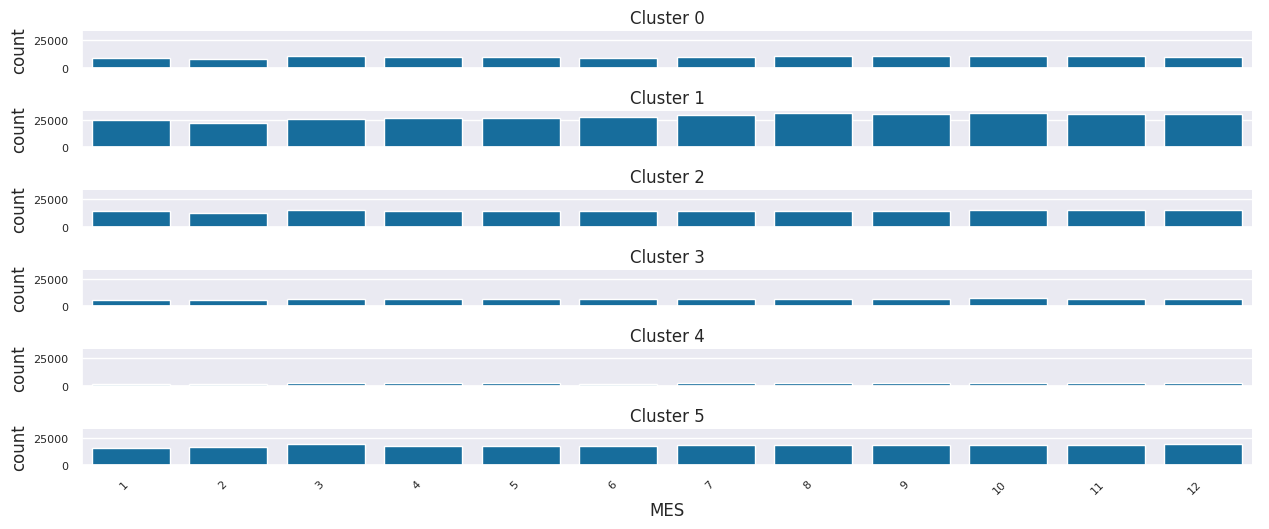

In [65]:
# pegando a contagem de registros por cluster e periodo
cluster_period_counts = df_km1.groupby(['cluster_mbk', 'MES']).size().reset_index(name='count')

# definindo a ordem dos periodos para plotagem
period_order = sorted(cluster_period_counts['MES'].unique())

# ordenar os dados por periodo para garantir a ordem correta no grafico
cluster_period_counts['MES'] = pd.Categorical(cluster_period_counts['MES'], categories=period_order, ordered=True)
cluster_period_counts = cluster_period_counts.sort_values('MES')

# Criar um catplot para visualizar a distribuicao dos clusters ao longo do tempo
g = sns.catplot(
    data=cluster_period_counts,
    x='MES',
    y='count',
    col='cluster_mbk',
    col_wrap=1,
    kind='bar',
    height=0.9,
    aspect=14,
    sharey=True,
    col_order=sorted(cluster_period_counts['cluster_mbk'].unique()),
)

# Rotacionar os rotulos do eixo x para melhor legibilidade
g.set_xticklabels(rotation=45, ha="right", fontsize=8) # Tamanho da fonte reduzido
g.set_titles("Cluster {col_name}", fontsize=9) # Reduzir o tamanho da fonte do titulo

# Define formatted_period_labels based on period_order
formatted_period_labels = [str(p) for p in period_order]

# Padronizar os limites e ticks do eixo x para todos os subplots
for ax in g.axes.flat:
    ax.set_xlim(-0.5, len(period_order) - 0.5)
    ax.set_xticks(range(len(period_order)))
    ax.set_xticklabels(formatted_period_labels, ha="right", fontsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()

plt.show()

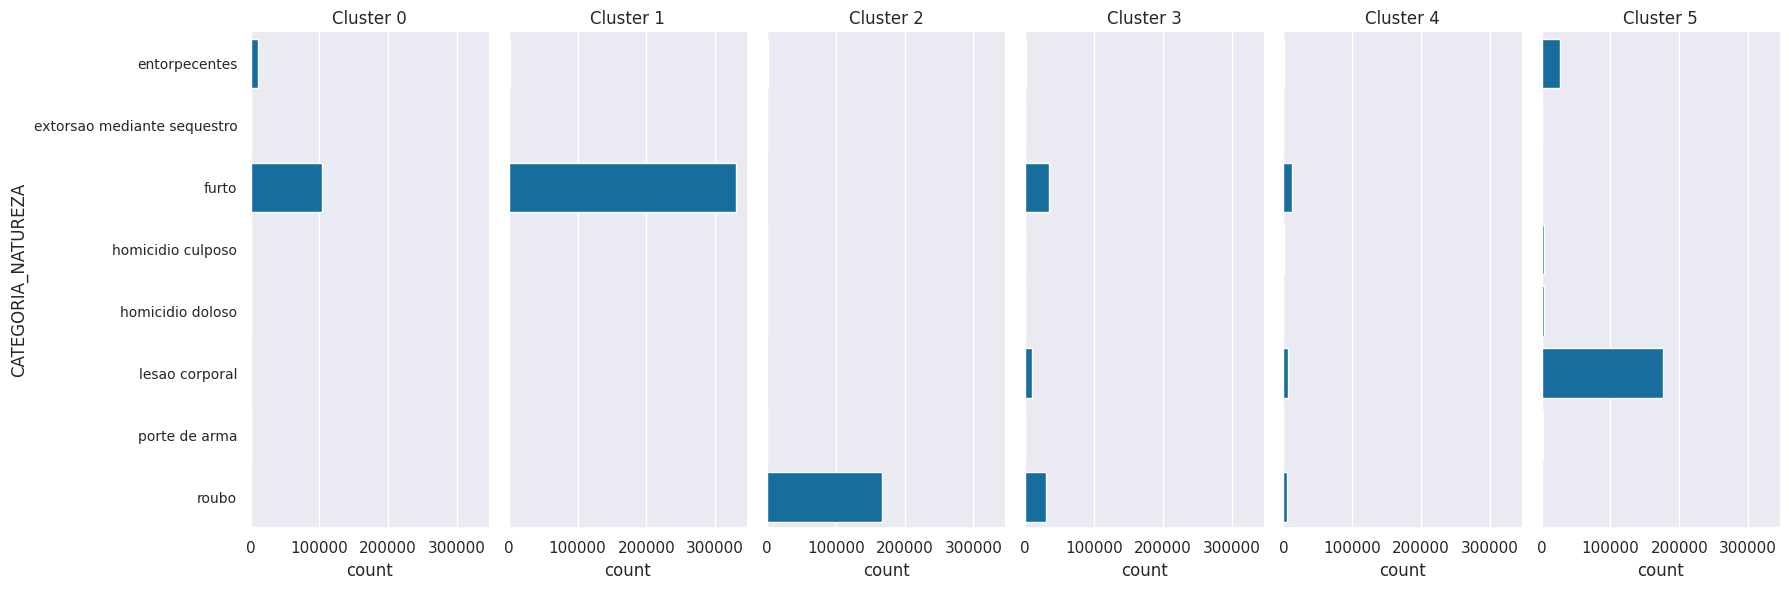

In [66]:
# pegando a contagem de categorias por cluster
cluster_category_counts = df_km1.groupby(['cluster_mbk', 'CATEGORIA_NATUREZA']).size().reset_index(name='count')

# definindo a ordem das categorias para o eixo y (opcional, mas útil para consistência)
category_order = sorted(cluster_category_counts['CATEGORIA_NATUREZA'].unique())

# Create a FacetGrid
g = sns.FacetGrid(
    cluster_category_counts,
    col='cluster_mbk',
    col_wrap=6,
    height=6,
    aspect=0.5,
    col_order=sorted(cluster_category_counts['cluster_mbk'].unique()),
    sharey=True
)

g.map(sns.barplot, 'count', 'CATEGORIA_NATUREZA', order=category_order)

for i, ax in enumerate(g.axes.flat):
    if i > 0:
        ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=10)

# Set titles for each subplot
g.set_titles("Cluster {col_name}")

plt.tight_layout()
plt.show()

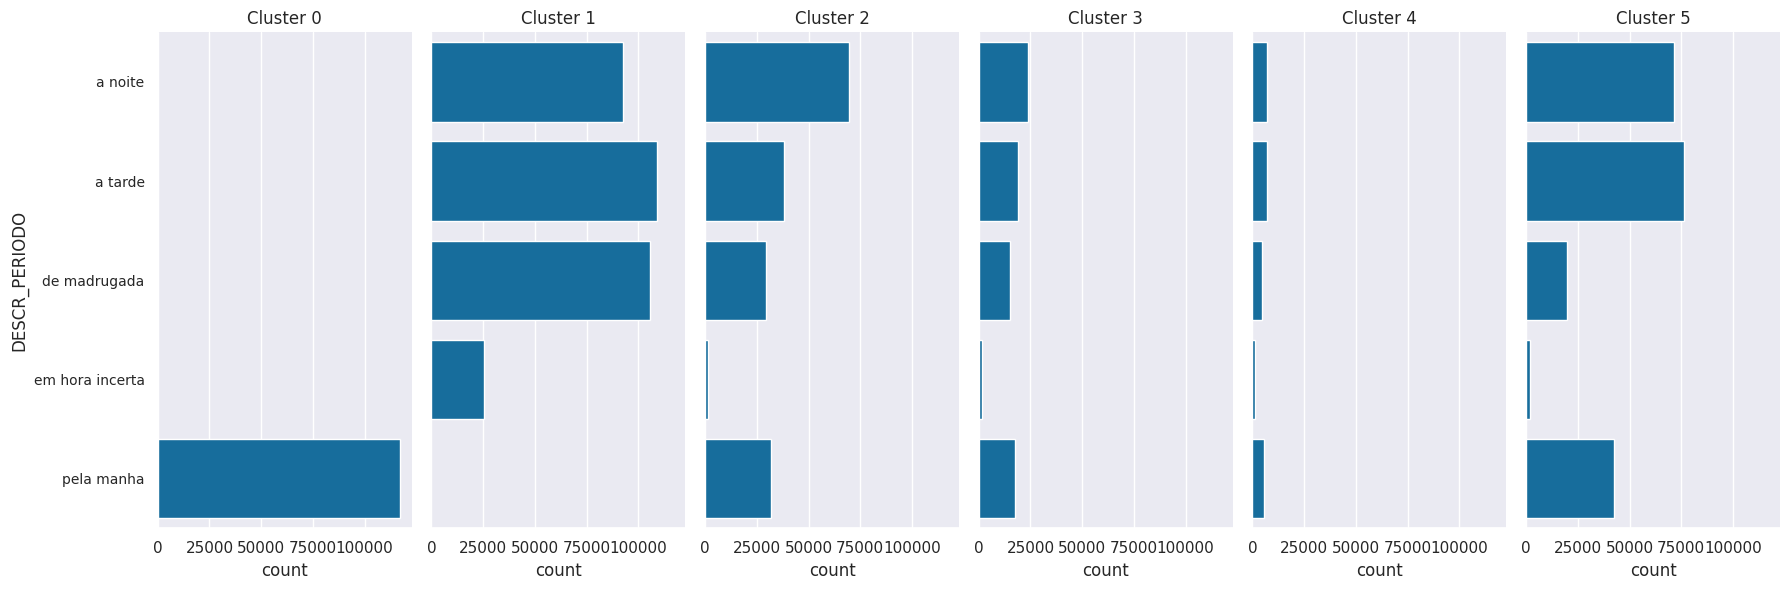

In [67]:
# pegando a contagem de categorias por cluster
cluster_category_counts = df_km1.groupby(['cluster_mbk', 'DESCR_PERIODO']).size().reset_index(name='count')

# definindo a ordem das categorias para o eixo y (opcional, mas útil para consistência)
category_order = sorted(cluster_category_counts['DESCR_PERIODO'].unique())

# Create a FacetGrid
g = sns.FacetGrid(
    cluster_category_counts,
    col='cluster_mbk',
    col_wrap=6,
    height=6,
    aspect=0.5,
    col_order=sorted(cluster_category_counts['cluster_mbk'].unique()),
    sharey=True
)

g.map(sns.barplot, 'count', 'DESCR_PERIODO', order=category_order)

for i, ax in enumerate(g.axes.flat):
    if i > 0:
        ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=10)

# Set titles for each subplot
g.set_titles("Cluster {col_name}")

plt.tight_layout()
plt.show()

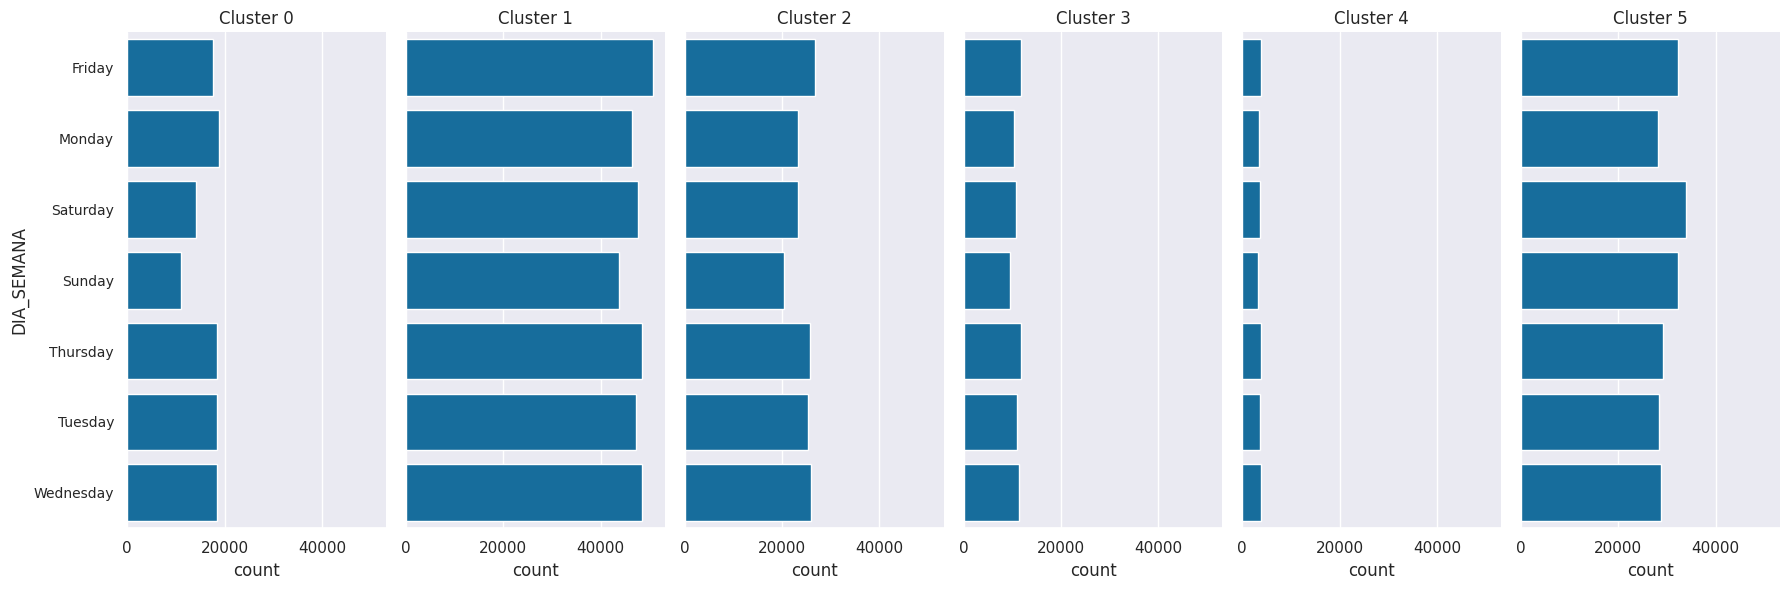

In [68]:
# pegando a contagem de categorias por cluster
cluster_category_counts = df_km1.groupby(['cluster_mbk', 'DIA_SEMANA']).size().reset_index(name='count')

# definindo a ordem das categorias para o eixo y (opcional, mas útil para consistência)
category_order = sorted(cluster_category_counts['DIA_SEMANA'].unique())

# Create a FacetGrid
g = sns.FacetGrid(
    cluster_category_counts,
    col='cluster_mbk',
    col_wrap=6,
    height=6,
    aspect=0.5,
    col_order=sorted(cluster_category_counts['cluster_mbk'].unique()),
    sharey=True
)

g.map(sns.barplot, 'count', 'DIA_SEMANA', order=category_order)

for i, ax in enumerate(g.axes.flat):
    if i > 0:
        ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=10)

# Set titles for each subplot
g.set_titles("Cluster {col_name}")

plt.tight_layout()
plt.show()

In [69]:
# médias, medianas e dispersão
cols_num = ["PIB_PER_CAPITA","DENSIDADE_DEMOGRAFICA"]
resumo_num = (
    df_km1.groupby("cluster_mbk")[cols_num]
         .agg(["mean","median","std","min","max"])
)

resumo_num

PIB_PER_CAPITA                                         \
                      mean    median      std       min       max   
cluster_mbk                                                         
0                 50191.61  49692.93 20258.61   9468.33 154054.53   
1                 49607.18  49692.93 19701.86   9468.33 139885.74   
2                 48884.65  50495.56 19558.50   9964.11 139885.74   
3                 72895.59  43031.91 43835.34  16909.54 122765.64   
4                243600.58 207460.98 94559.52 154054.53 457517.70   
5                 47616.89  44679.93 19932.48   9468.33 154054.53   

            DENSIDADE_DEMOGRAFICA                                     
                             mean   median     std      min      max  
cluster_mbk                                                           
0                         1486.25  1027.87 1594.06     3.51  6765.14  
1                         1421.61  1027.87 1550.61     3.51  6765.14  
2                         2286.53  1979.65 1794.58     5.60  6765.14  
3                        11823.16 11217.40  900.07 10805.23 13416.81  
4                         1975.11   796.51 1998.55    13.90  4816.87  
5                          838.80   307.19 1211.27     3.51  6765.14

Podemos observar que os padrões se repetiram para todos os clusters.

# 6. Conclusão
O trabalho apresentou clusters inconclusivos. Provavelmente seria necessário reunir uma quantidade maior de informações para estratificar regras de registro de crimes.

Os modelos não tiveram desempenho satisfatório, com muito overlap de clusters, causando pouca especificidade nos grupos, um trabalho complementar é necessário.

# 7. Autoavaliação

O projeto se tornou um grande desafio. Trabalhar com dados reais, principalmente com dados relacionados à segurança pública, exigem um cuidado e preciosismos muito grandes, fazendo com que o tempo de tratamento dos dados se torne muito maior que o natural.

Além disso, ao tratarmos de dados reais, existe a necessidade de testar, validar e alterar os atributos com uma frequência muito alta, o que faz com que o trabalho vá e volte nas seções diversas vezes. Ao tentar manter o trabalho organizado, acabei tendo o retrabalho de voltar diversas vezes nas etapas para ajustar o que fosse necessário, mas, com o tempo ficando cada vez mais curto, tive que tomar a decisão de mudar a rota no meio do caminho e ir documentando da melhor forma (espero que tenha sido claro e suficiente).

Por fim listo as melhorias que eu realizaria no trabalho com mais tempo:
- Trataria ainda mais os atributos, desenvolvendo novas features e checando como se comportam nos modelos;
- Desenvolvimento de modelos diferentes;
- Desenvolvimento do estudo por hotspots, utilizando LATITUDE e LONGITUDE;